In [ ]:
pip install yfinance pandas scikit-learn matplotlib

In [ ]:
pip install yfinance matplotlib pandas

Experiment with Random Forest without tuning (Not Optimal for Trading)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


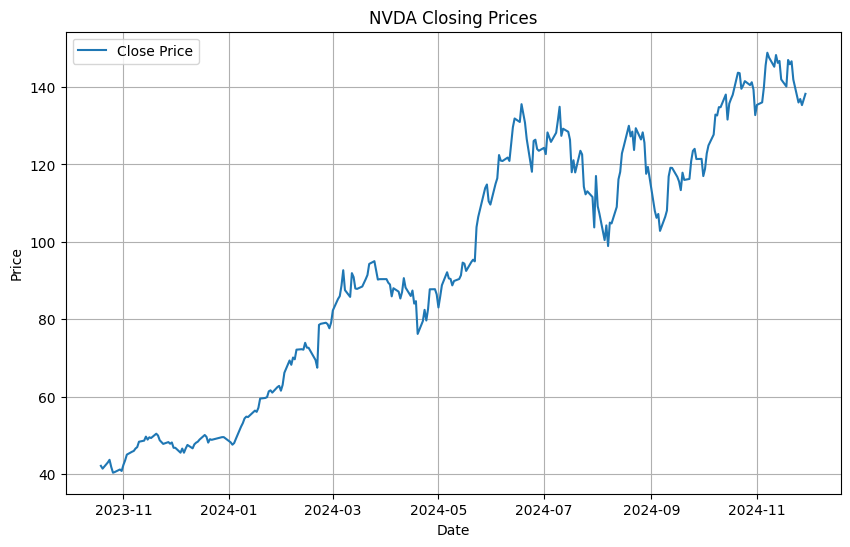

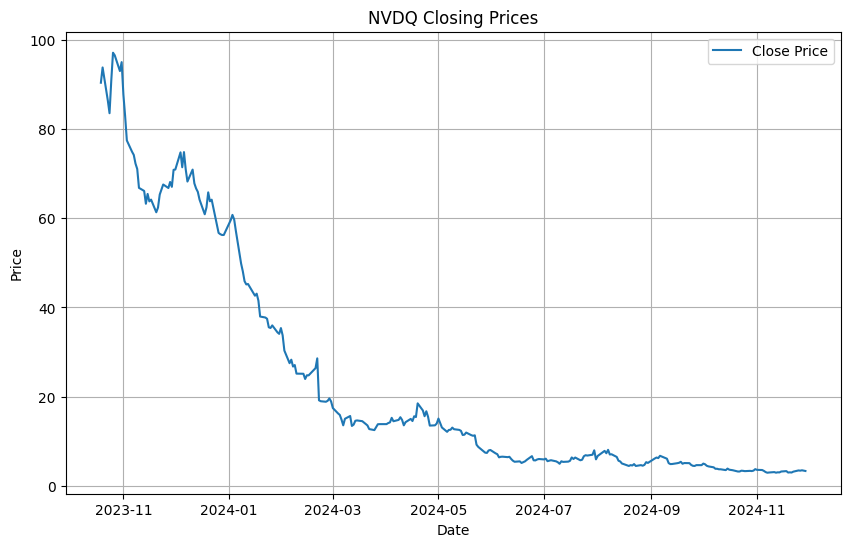


Correlation between NVDA and NVDQ prices:
Price           Close         
Ticker           NVDA     NVDQ
Price Ticker                  
Close NVDA    1.00000 -0.88437
      NVDQ   -0.88437  1.00000
Calculating features...
Features calculated.
Calculating features...
Features calculated.
Generating target columns...
Target columns generated.
Generating target columns...
Target columns generated.
Splitting data into training and testing sets...
Training models...
Models trained successfully!

Model Evaluation Metrics:
NVDA Max Price - MSE: 50.26, R2: 0.62
NVDA Min Price - MSE: 118.86, R2: 0.39
NVDA Avg Price - MSE: 101.96, R2: 0.34
NVDQ Max Price - MSE: 3.38, R2: -0.21
NVDQ Min Price - MSE: 1.17, R2: -0.09
NVDQ Avg Price - MSE: 2.48, R2: -0.48
Saving models...
Models saved successfully!


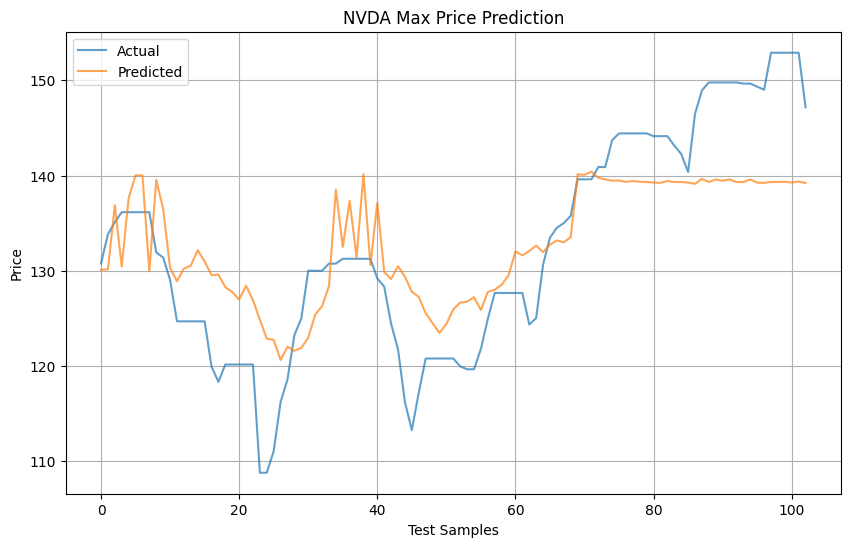

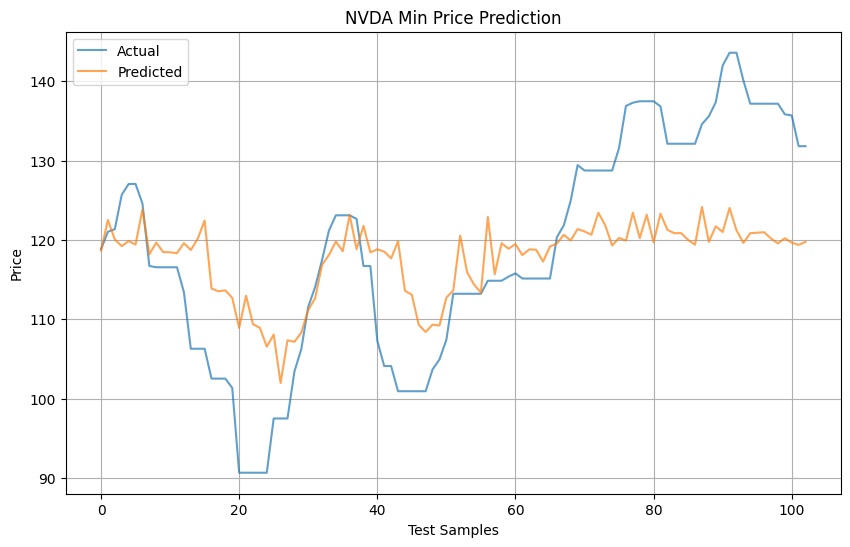

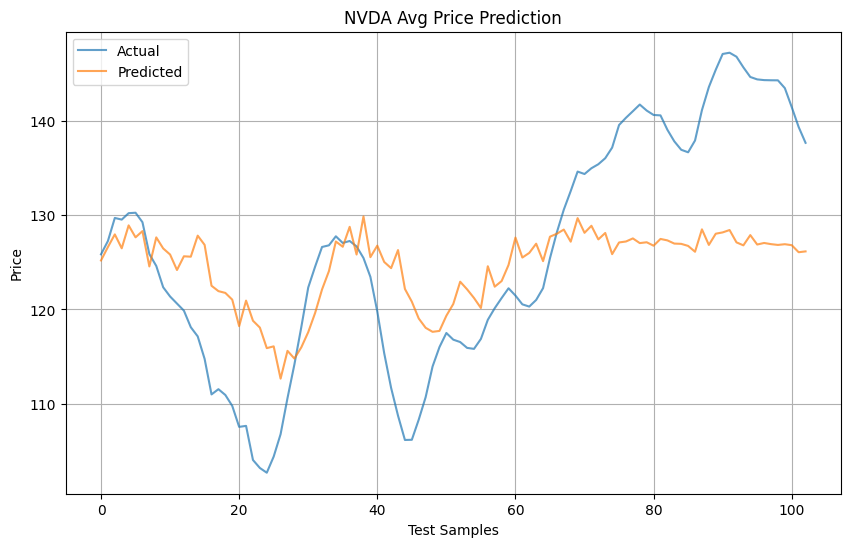

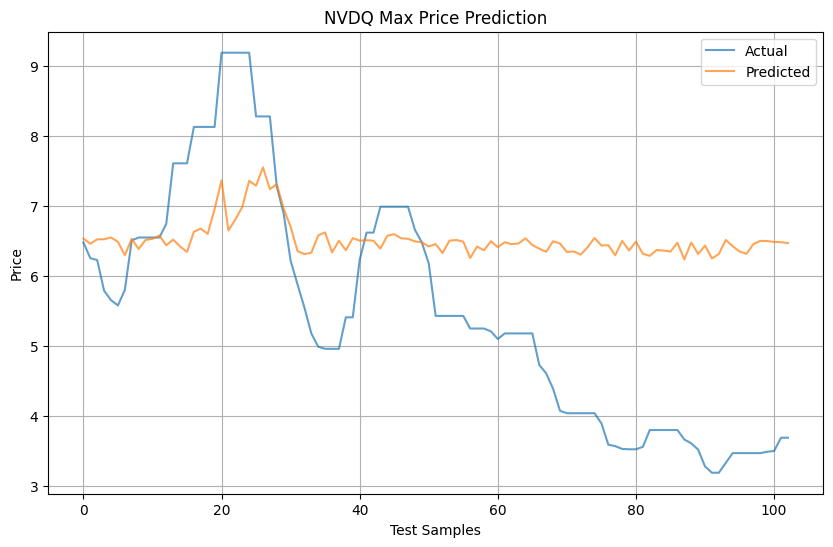

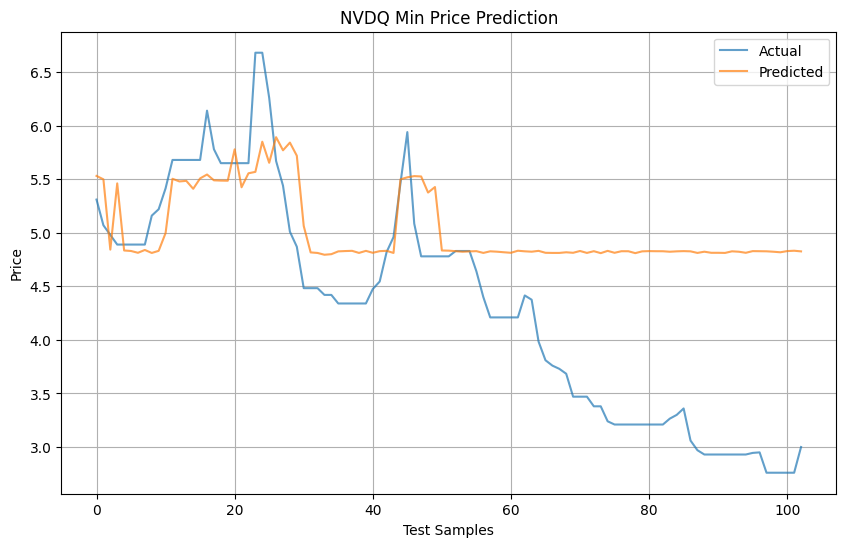

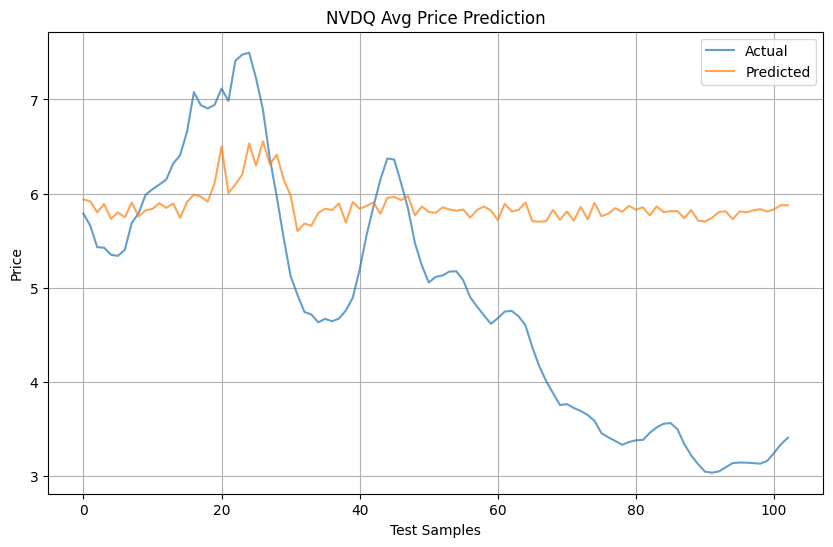

Pipeline Complete: From Data Download to Model Training, Evaluation, and Visualization.


In [58]:
# Install Required Libraries (if needed)
# !pip install yfinance matplotlib pandas scikit-learn joblib

# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Step 1: Download Historical Data
def download_data(ticker, start_date, end_date):
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Ticker'] = ticker  # Add a column to identify the stock
    return data

# Define the tickers and date range
tickers = ['NVDA', 'NVDQ']
start_date = '2023-10-19'  # Start date based on NVDQ's availability
end_date = '2024-12-01'

# Download data for NVDA and NVDQ
nvda_data = download_data('NVDA', start_date, end_date)
nvdq_data = download_data('NVDQ', start_date, end_date)

# Step 2: Data Exploration and Visualization
def plot_stock_data(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data['Close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Plot price trends
plot_stock_data(nvda_data, "NVDA Closing Prices")
plot_stock_data(nvdq_data, "NVDQ Closing Prices")

# Step 3: Correlation Analysis
merged_data = pd.merge(
    nvda_data[['Close']],
    nvdq_data[['Close']],
    left_index=True,
    right_index=True,
    suffixes=('_NVDA', '_NVDQ')
)
correlation = merged_data.corr()
print("\nCorrelation between NVDA and NVDQ prices:")
print(correlation)

# Step 4: Feature Engineering
def calculate_features(data):
    print("Calculating features...")
    data['5-Day MA'] = data['Close'].rolling(window=5).mean()  # 5-day moving average
    data['10-Day MA'] = data['Close'].rolling(window=10).mean()  # 10-day moving average
    data['Daily Return (%)'] = data['Close'].pct_change() * 100  # Daily return percentage
    data['Volatility'] = (data['High'] - data['Low']) / data['Low'] * 100  # Volatility
    data['Day_Of_Week'] = data.index.dayofweek  # Day of the week
    print("Features calculated.")
    return data

# Add features to NVDA and NVDQ datasets
nvda_data = calculate_features(nvda_data)
nvdq_data = calculate_features(nvdq_data)

# Step 5: Generate Targets
def generate_targets(data):
    print("Generating target columns...")
    data['Target_Max'] = data['High'].rolling(window=5).max().shift(-4)
    data['Target_Min'] = data['Low'].rolling(window=5).min().shift(-4)
    data['Target_Avg'] = data['Close'].rolling(window=5).mean().shift(-4)
    print("Target columns generated.")
    return data

nvda_data = generate_targets(nvda_data)
nvdq_data = generate_targets(nvdq_data)

# Drop rows with NaN values due to shifting
nvda_data.dropna(inplace=True)
nvdq_data.dropna(inplace=True)

# Step 6: Train-Test Split
def train_test_split(data, split_date):
    train = data.loc[:split_date]
    test = data.loc[split_date:]
    return train, test

print("Splitting data into training and testing sets...")
split_date = '2024-06-30'
features = ['Close', '5-Day MA', '10-Day MA', 'Daily Return (%)', 'Volatility', 'Day_Of_Week']

# NVDA Split
train_nvda, test_nvda = train_test_split(nvda_data, split_date)
X_train_nvda = train_nvda[features]
X_test_nvda = test_nvda[features]
y_train_max_nvda = train_nvda['Target_Max']
y_test_max_nvda = test_nvda['Target_Max']
y_train_min_nvda = train_nvda['Target_Min']
y_test_min_nvda = test_nvda['Target_Min']
y_train_avg_nvda = train_nvda['Target_Avg']
y_test_avg_nvda = test_nvda['Target_Avg']

# NVDQ Split
train_nvdq, test_nvdq = train_test_split(nvdq_data, split_date)
X_train_nvdq = train_nvdq[features]
X_test_nvdq = test_nvdq[features]
y_train_max_nvdq = train_nvdq['Target_Max']
y_test_max_nvdq = test_nvdq['Target_Max']
y_train_min_nvdq = train_nvdq['Target_Min']
y_test_min_nvdq = test_nvdq['Target_Min']
y_train_avg_nvdq = train_nvdq['Target_Avg']
y_test_avg_nvdq = test_nvdq['Target_Avg']

# Step 7: Train Models
def train_models(X_train, y_train_max, y_train_min, y_train_avg):
    model_max = RandomForestRegressor(n_estimators=100, random_state=42)
    model_min = RandomForestRegressor(n_estimators=100, random_state=42)
    model_avg = RandomForestRegressor(n_estimators=100, random_state=42)
    model_max.fit(X_train, y_train_max)
    model_min.fit(X_train, y_train_min)
    model_avg.fit(X_train, y_train_avg)
    return model_max, model_min, model_avg

print("Training models...")
model_max_nvda, model_min_nvda, model_avg_nvda = train_models(X_train_nvda, y_train_max_nvda, y_train_min_nvda, y_train_avg_nvda)
model_max_nvdq, model_min_nvdq, model_avg_nvdq = train_models(X_train_nvdq, y_train_max_nvdq, y_train_min_nvdq, y_train_avg_nvdq)
print("Models trained successfully!")

# Step 8: Evaluate Models
def evaluate_model(model, X_test, y_test, target_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{target_name} - MSE: {mse:.2f}, R2: {r2:.2f}")
    return y_pred

print("\nModel Evaluation Metrics:")
# NVDA Evaluation
y_pred_max_nvda = evaluate_model(model_max_nvda, X_test_nvda, y_test_max_nvda, "NVDA Max Price")
y_pred_min_nvda = evaluate_model(model_min_nvda, X_test_nvda, y_test_min_nvda, "NVDA Min Price")
y_pred_avg_nvda = evaluate_model(model_avg_nvda, X_test_nvda, y_test_avg_nvda, "NVDA Avg Price")

# NVDQ Evaluation
y_pred_max_nvdq = evaluate_model(model_max_nvdq, X_test_nvdq, y_test_max_nvdq, "NVDQ Max Price")
y_pred_min_nvdq = evaluate_model(model_min_nvdq, X_test_nvdq, y_test_min_nvdq, "NVDQ Min Price")
y_pred_avg_nvdq = evaluate_model(model_avg_nvdq, X_test_nvdq, y_test_avg_nvdq, "NVDQ Avg Price")

# Step 9: Save Models
print("Saving models...")
joblib.dump(model_max_nvda, 'nvda_max_price_model.pkl')
joblib.dump(model_min_nvda, 'nvda_min_price_model.pkl')
joblib.dump(model_avg_nvda, 'nvda_avg_price_model.pkl')
joblib.dump(model_max_nvdq, 'nvdq_max_price_model.pkl')
joblib.dump(model_min_nvdq, 'nvdq_min_price_model.pkl')
joblib.dump(model_avg_nvdq, 'nvdq_avg_price_model.pkl')
print("Models saved successfully!")

# Step 10: Visualization
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.values, label='Actual', alpha=0.7)
    plt.plot(predicted, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel('Test Samples')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# NVDA Plots
plot_predictions(y_test_max_nvda, y_pred_max_nvda, "NVDA Max Price Prediction")
plot_predictions(y_test_min_nvda, y_pred_min_nvda, "NVDA Min Price Prediction")
plot_predictions(y_test_avg_nvda, y_pred_avg_nvda, "NVDA Avg Price Prediction")

# NVDQ Plots
plot_predictions(y_test_max_nvdq, y_pred_max_nvdq, "NVDQ Max Price Prediction")
plot_predictions(y_test_min_nvdq, y_pred_min_nvdq, "NVDQ Min Price Prediction")
plot_predictions(y_test_avg_nvdq, y_pred_avg_nvdq, "NVDQ Avg Price Prediction")

print("Pipeline Complete: From Data Download to Model Training, Evaluation, and Visualization.")



Experiment with Random Forest with tuning (Still Not Optimal for Trading)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Preprocessing NVDA data...
Calculating features...
Generating target columns...
NVDA data preprocessed and saved to 'nvda_preprocessed.csv'.
Preprocessing NVDQ data...
Calculating features...
Generating target columns...
NVDQ data preprocessed and saved to 'nvdq_preprocessed.csv'.
Training models...


Saving models...
Models saved successfully!

Model Evaluation Metrics:
NVDA Max Price - MSE: 127.20, R2: 0.04
NVDA Min Price - MSE: 184.38, R2: 0.06
NVDA Avg Price - MSE: 167.00, R2: -0.08
NVDQ Max Price - MSE: 12.65, R2: -3.53
NVDQ Min Price - MSE: 7.84, R2: -6.33
NVDQ Avg Price - MSE: 10.29, R2: -5.16


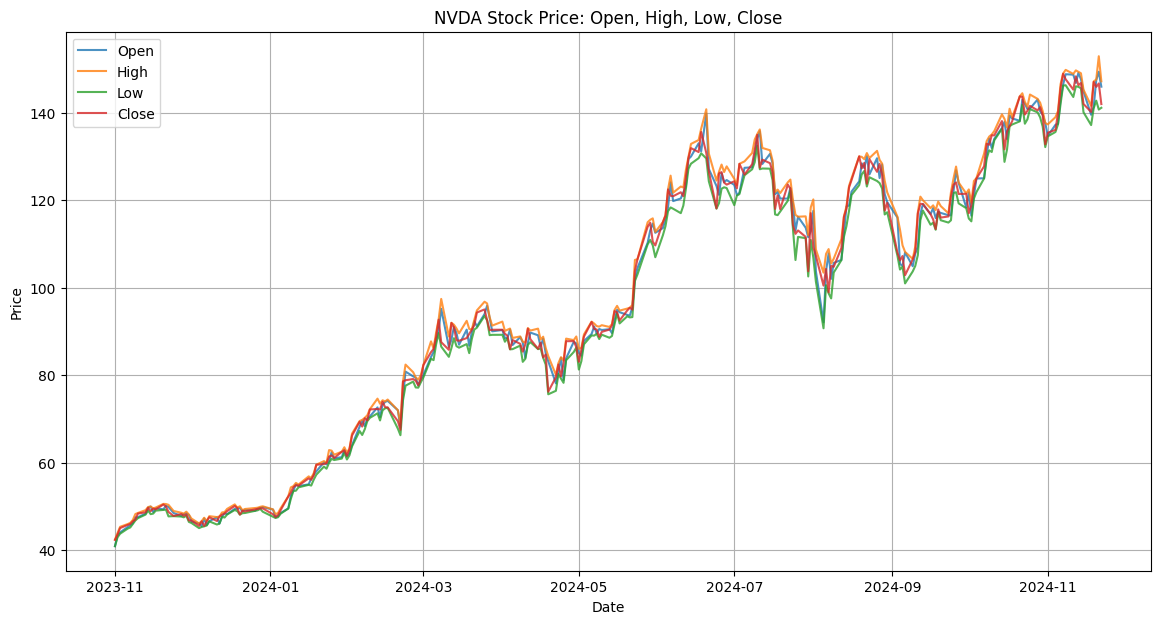

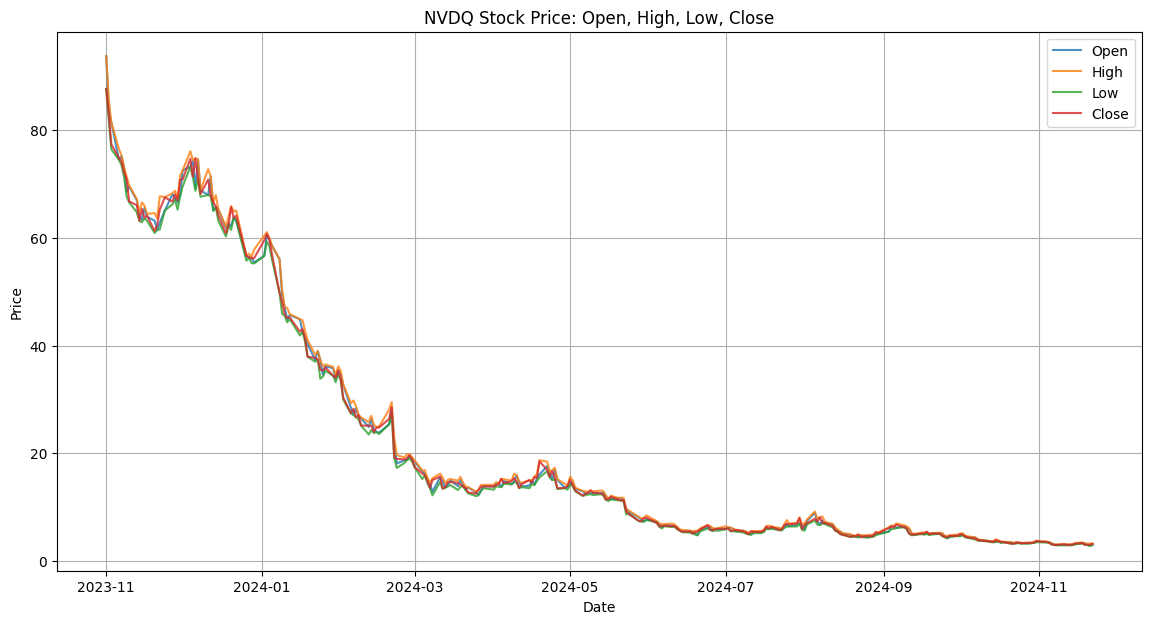

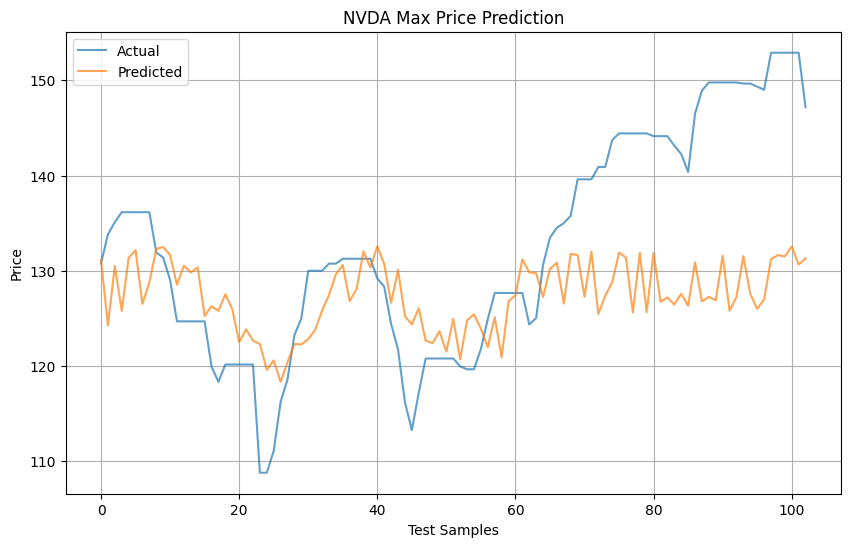

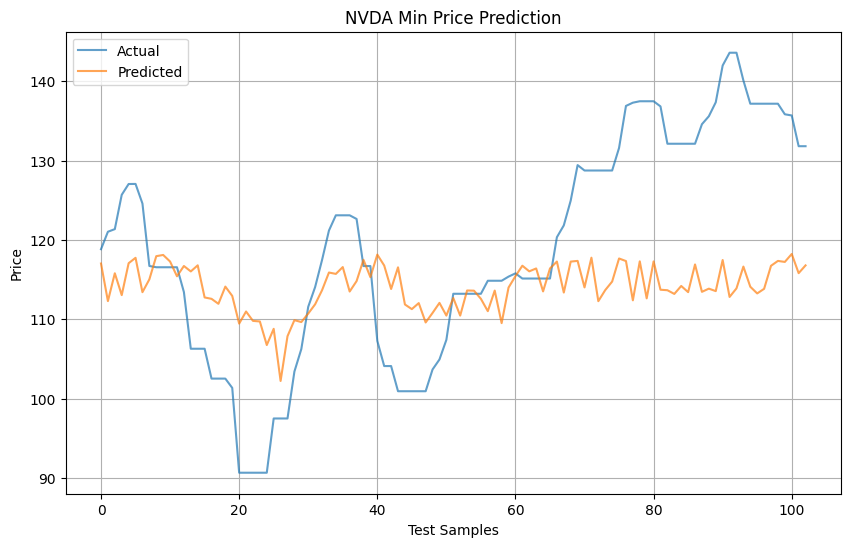

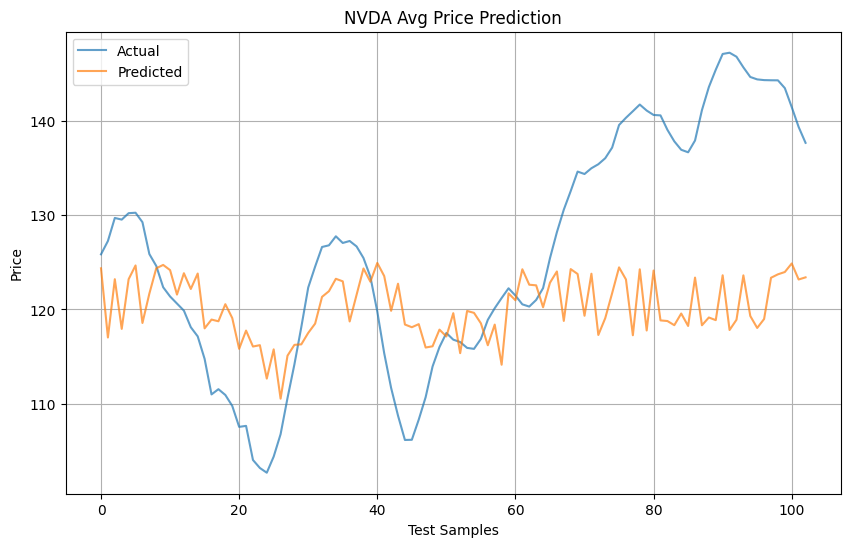

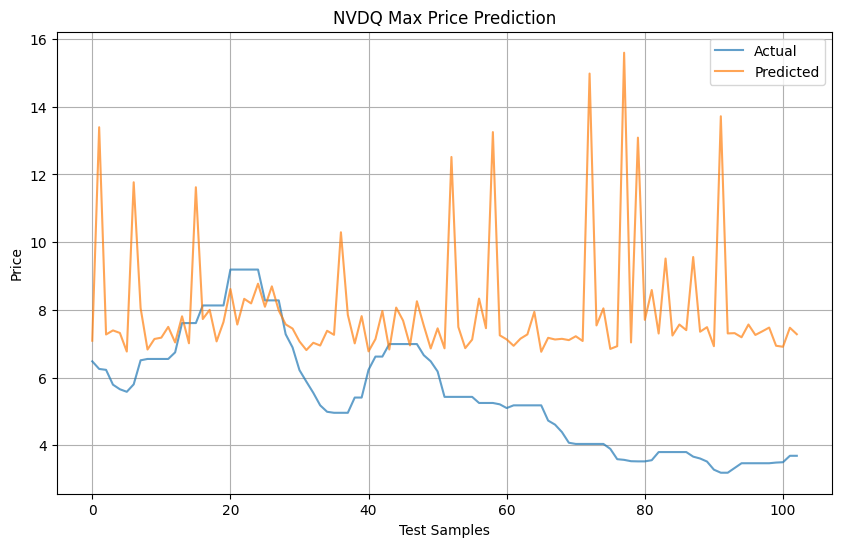

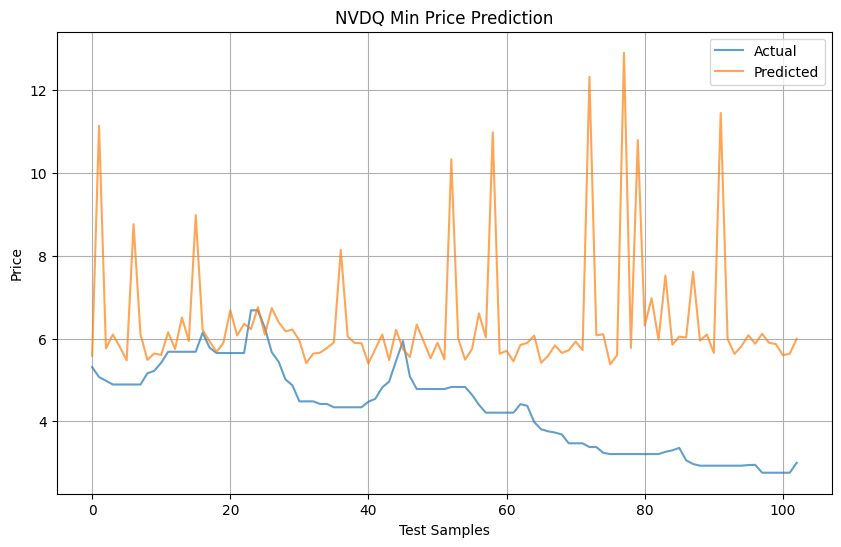

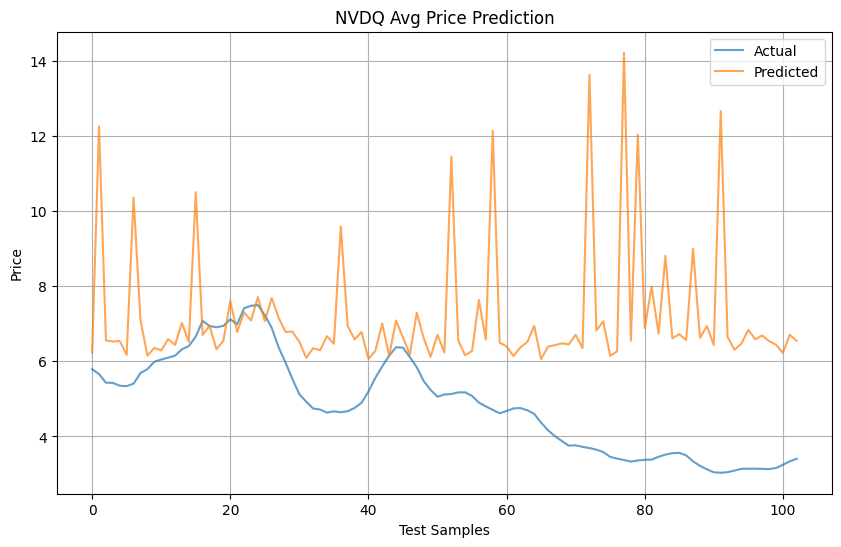

Pipeline Complete: Data preprocessing, saving CSVs, model training, evaluation, and visualization.


In [59]:
# Install Required Libraries (if needed)
# !pip install yfinance matplotlib pandas scikit-learn joblib

# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt

# Step 1: Download Historical Data
def download_data(ticker, start_date, end_date):
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Ticker'] = ticker  # Add a column to identify the stock
    return data

# Step 2: Preprocessing to Add Day_Of_Week and Volatility
def preprocess_csv(data, ticker):
    print(f"Preprocessing {ticker} data...")
    data['Volatility'] = (data['High'] - data['Low']) / data['Low'] * 100
    data['Day_Of_Week'] = data.index.dayofweek
    return data

# Step 3: Feature Engineering
def calculate_features(data):
    print("Calculating features...")
    data['5-Day MA'] = data['Close'].rolling(window=5).mean()
    data['10-Day MA'] = data['Close'].rolling(window=10).mean()
    data['Daily Return (%)'] = data['Close'].pct_change() * 100
    return data

# Step 4: Generate Targets
def generate_targets(data):
    print("Generating target columns...")
    data['Target_Max'] = data['High'].rolling(window=5).max().shift(-4)
    data['Target_Min'] = data['Low'].rolling(window=5).min().shift(-4)
    data['Target_Avg'] = data['Close'].rolling(window=5).mean().shift(-4)
    return data

# Define the tickers and date range
tickers = ['NVDA', 'NVDQ']
start_date = '2023-10-19'
end_date = '2024-12-01'

# Download, preprocess, and save data for NVDA and NVDQ
print("Downloading and preprocessing data...")
nvda_data = download_data('NVDA', start_date, end_date)
nvda_data = preprocess_csv(nvda_data, 'NVDA')
nvda_data = calculate_features(nvda_data)
nvda_data = generate_targets(nvda_data)
nvda_data.dropna(inplace=True)
nvda_data.to_csv('nvda_preprocessed.csv')  # Save preprocessed NVDA data
print("NVDA data preprocessed and saved to 'nvda_preprocessed.csv'.")

nvdq_data = download_data('NVDQ', start_date, end_date)
nvdq_data = preprocess_csv(nvdq_data, 'NVDQ')
nvdq_data = calculate_features(nvdq_data)
nvdq_data = generate_targets(nvdq_data)
nvdq_data.dropna(inplace=True)
nvdq_data.to_csv('nvdq_preprocessed.csv')  # Save preprocessed NVDQ data
print("NVDQ data preprocessed and saved to 'nvdq_preprocessed.csv'.")

# Step 5: Train-Test Split
def train_test_split(data, split_date):
    train = data.loc[:split_date]
    test = data.loc[split_date:]
    return train, test

split_date = '2024-06-30'
features = ['Close', '5-Day MA', '10-Day MA', 'Daily Return (%)', 'Volatility', 'Day_Of_Week']

# NVDA Split
train_nvda, test_nvda = train_test_split(nvda_data, split_date)
X_train_nvda = train_nvda[features]
X_test_nvda = test_nvda[features]
y_train_max_nvda = train_nvda['Target_Max']
y_test_max_nvda = test_nvda['Target_Max']
y_train_min_nvda = train_nvda['Target_Min']
y_test_min_nvda = test_nvda['Target_Min']
y_train_avg_nvda = train_nvda['Target_Avg']
y_test_avg_nvda = test_nvda['Target_Avg']

# NVDQ Split
train_nvdq, test_nvdq = train_test_split(nvdq_data, split_date)
X_train_nvdq = train_nvdq[features]
X_test_nvdq = test_nvdq[features]
y_train_max_nvdq = train_nvdq['Target_Max']
y_test_max_nvdq = test_nvdq['Target_Max']
y_train_min_nvdq = train_nvdq['Target_Min']
y_test_min_nvdq = test_nvdq['Target_Min']
y_train_avg_nvdq = train_nvdq['Target_Avg']
y_test_avg_nvdq = test_nvdq['Target_Avg']

def train_models(X_train, y_train_max, y_train_min, y_train_avg):
    model_max = RandomForestRegressor(
        n_estimators=200,          # Increased number of trees
        max_depth=10,              # Limit tree depth
        min_samples_split=10,      # Minimum samples to split a node
        min_samples_leaf=5,        # Minimum samples per leaf
        max_features='sqrt',       # Limit features to sqrt
        bootstrap=True,            # Use bootstrap sampling
        random_state=42            # Reproducibility
    )
    model_min = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10,
                                      min_samples_leaf=5, max_features='sqrt', bootstrap=True,
                                      random_state=42)
    model_avg = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10,
                                      min_samples_leaf=5, max_features='sqrt', bootstrap=True,
                                      random_state=42)

    # Train models
    model_max.fit(X_train, y_train_max)
    model_min.fit(X_train, y_train_min)
    model_avg.fit(X_train, y_train_avg)
    return model_max, model_min, model_avg


print("Training models...")
model_max_nvda, model_min_nvda, model_avg_nvda = train_models(X_train_nvda, y_train_max_nvda, y_train_min_nvda, y_train_avg_nvda)
model_max_nvdq, model_min_nvdq, model_avg_nvdq = train_models(X_train_nvdq, y_train_max_nvdq, y_train_min_nvdq, y_train_avg_nvdq)

# Step 7: Save Models
print("Saving models...")
joblib.dump(model_max_nvda, 'nvda_max_price_model.pkl')
joblib.dump(model_min_nvda, 'nvda_min_price_model.pkl')
joblib.dump(model_avg_nvda, 'nvda_avg_price_model.pkl')
joblib.dump(model_max_nvdq, 'nvdq_max_price_model.pkl')
joblib.dump(model_min_nvdq, 'nvdq_min_price_model.pkl')
joblib.dump(model_avg_nvdq, 'nvdq_avg_price_model.pkl')
print("Models saved successfully!")

# Step 8: Evaluate Models
def evaluate_model(model, X_test, y_test, target_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{target_name} - MSE: {mse:.2f}, R2: {r2:.2f}")
    return y_pred

print("\nModel Evaluation Metrics:")
y_pred_max_nvda = evaluate_model(model_max_nvda, X_test_nvda, y_test_max_nvda, "NVDA Max Price")
y_pred_min_nvda = evaluate_model(model_min_nvda, X_test_nvda, y_test_min_nvda, "NVDA Min Price")
y_pred_avg_nvda = evaluate_model(model_avg_nvda, X_test_nvda, y_test_avg_nvda, "NVDA Avg Price")

y_pred_max_nvdq = evaluate_model(model_max_nvdq, X_test_nvdq, y_test_max_nvdq, "NVDQ Max Price")
y_pred_min_nvdq = evaluate_model(model_min_nvdq, X_test_nvdq, y_test_min_nvdq, "NVDQ Min Price")
y_pred_avg_nvdq = evaluate_model(model_avg_nvdq, X_test_nvdq, y_test_avg_nvdq, "NVDQ Avg Price")

# Step 9: Visualization - OHLC Actual Data
def plot_ohlc(data, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Open'], label='Open', alpha=0.8)
    plt.plot(data.index, data['High'], label='High', alpha=0.8)
    plt.plot(data.index, data['Low'], label='Low', alpha=0.8)
    plt.plot(data.index, data['Close'], label='Close', alpha=0.8)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Plot NVDA OHLC data
plot_ohlc(nvda_data, 'NVDA Stock Price: Open, High, Low, Close')

# Plot NVDQ OHLC data
plot_ohlc(nvdq_data, 'NVDQ Stock Price: Open, High, Low, Close')

# Step 10: Visualization
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.values, label='Actual', alpha=0.7)
    plt.plot(predicted, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel('Test Samples')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# NVDA Plots
plot_predictions(y_test_max_nvda, y_pred_max_nvda, "NVDA Max Price Prediction")
plot_predictions(y_test_min_nvda, y_pred_min_nvda, "NVDA Min Price Prediction")
plot_predictions(y_test_avg_nvda, y_pred_avg_nvda, "NVDA Avg Price Prediction")

# NVDQ Plots
plot_predictions(y_test_max_nvdq, y_pred_max_nvdq, "NVDQ Max Price Prediction")
plot_predictions(y_test_min_nvdq, y_pred_min_nvdq, "NVDQ Min Price Prediction")
plot_predictions(y_test_avg_nvdq, y_pred_avg_nvdq, "NVDQ Avg Price Prediction")

print("Pipeline Complete: Data preprocessing, saving CSVs, model training, evaluation, and visualization.")


XGBOOST - Finialized Pipeline (Optimal for Trafing Predictions) Way better than Random Forest)

[*********************100%***********************]  1 of 1 completed


Processing NVDA...
Raw data saved to nvda_raw.csv
Calculating features...
Generating targets...
Preprocessed data saved to nvda_preprocessed.csv


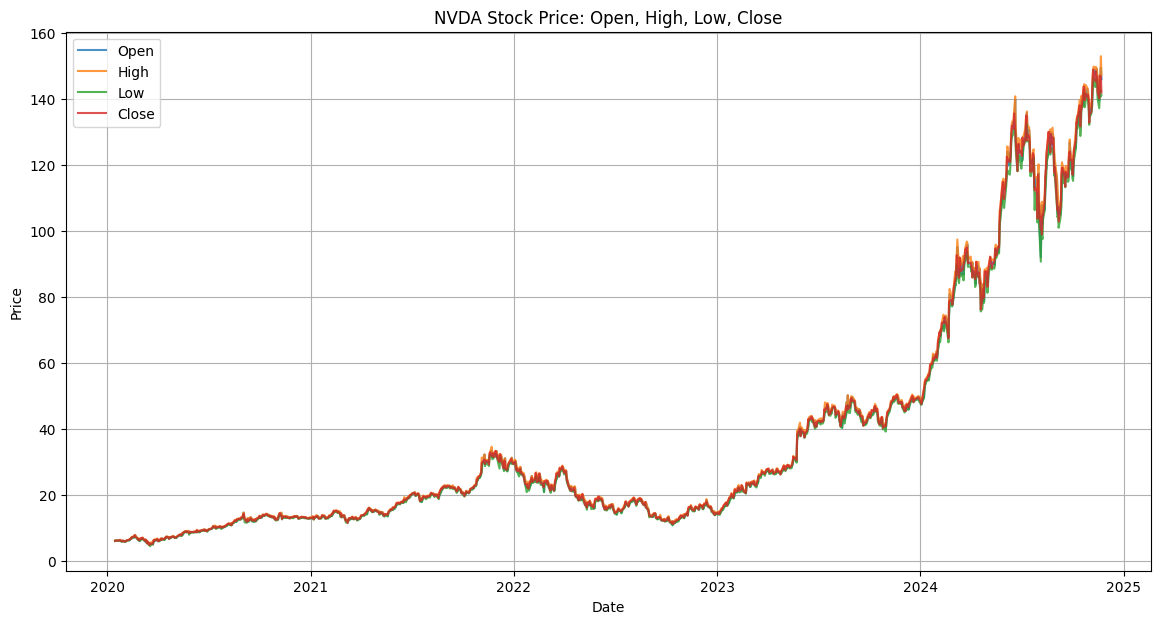


Training model for NVDA - Max Price...
Training XGBoost model with tuned hyperparameters...
NVDA Max Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvda_max_xgboost_model.pkl


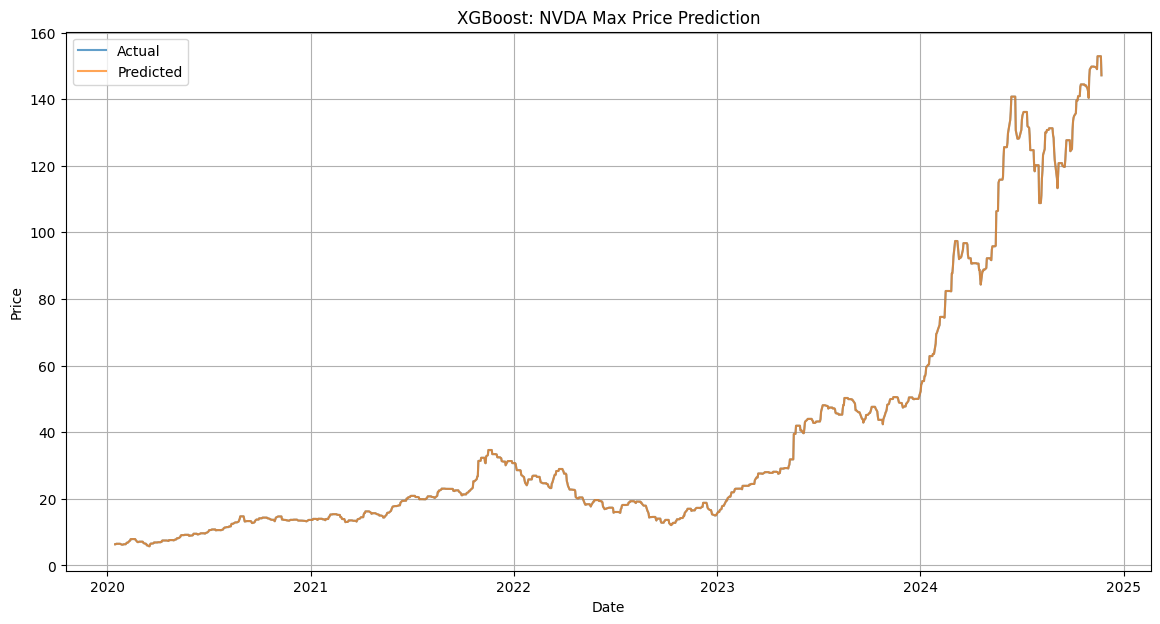

Plotting feature importance for NVDA - Max Price...


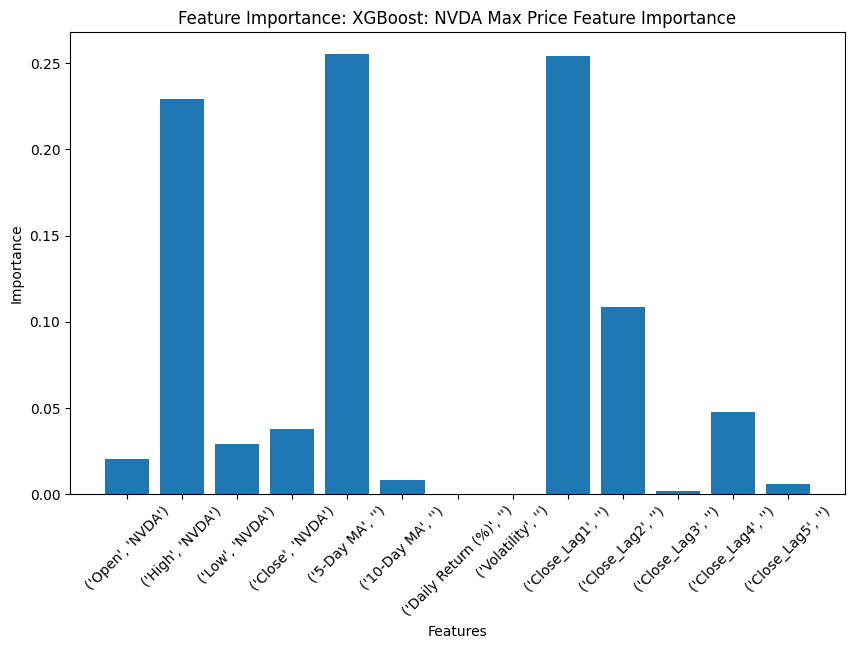


Training model for NVDA - Min Price...
Training XGBoost model with tuned hyperparameters...
NVDA Min Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvda_min_xgboost_model.pkl


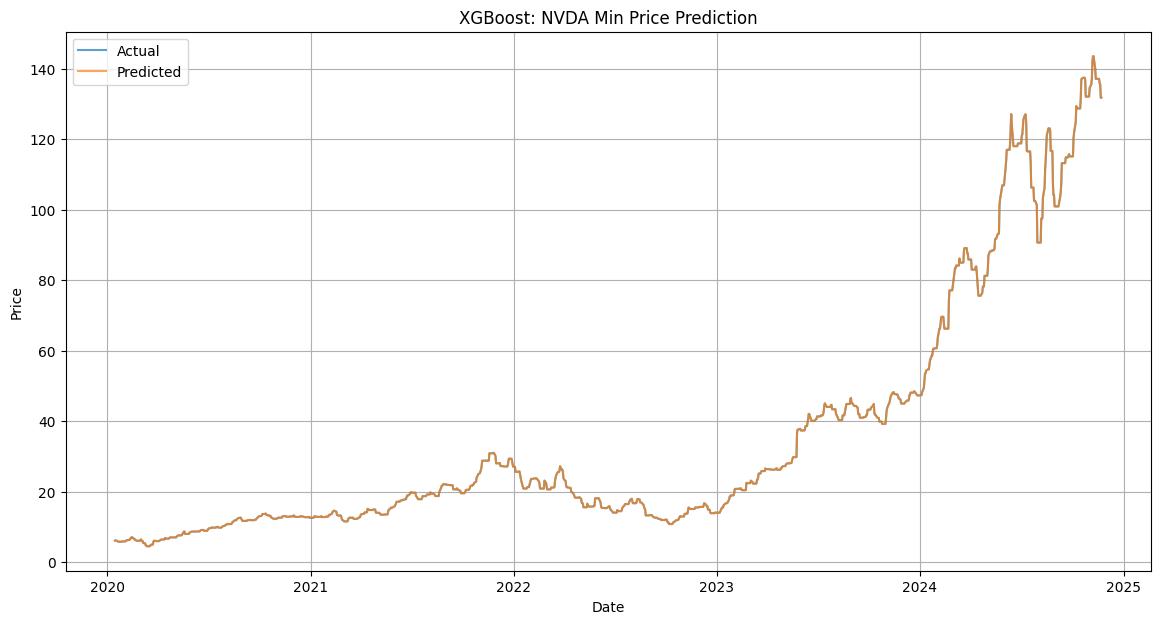

Plotting feature importance for NVDA - Min Price...


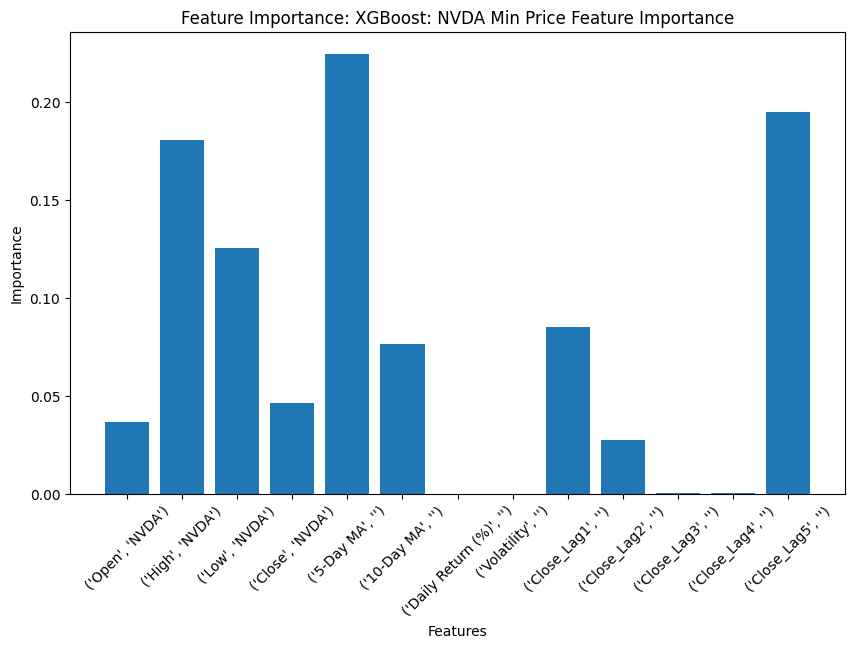


Training model for NVDA - Avg Price...
Training XGBoost model with tuned hyperparameters...
NVDA Avg Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvda_avg_xgboost_model.pkl


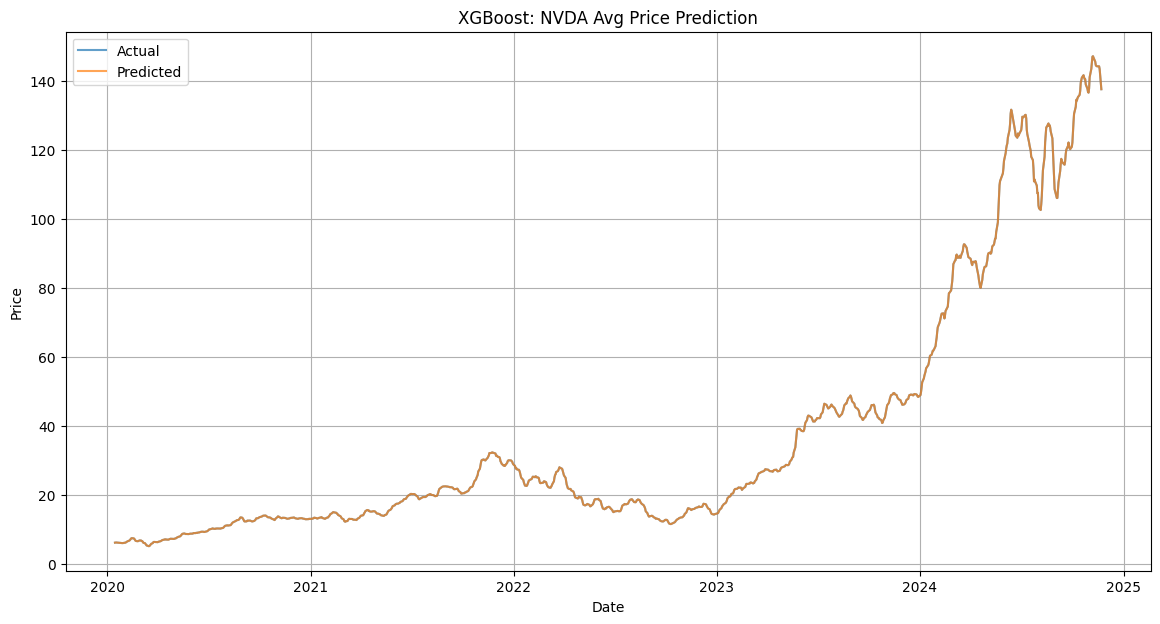

Plotting feature importance for NVDA - Avg Price...


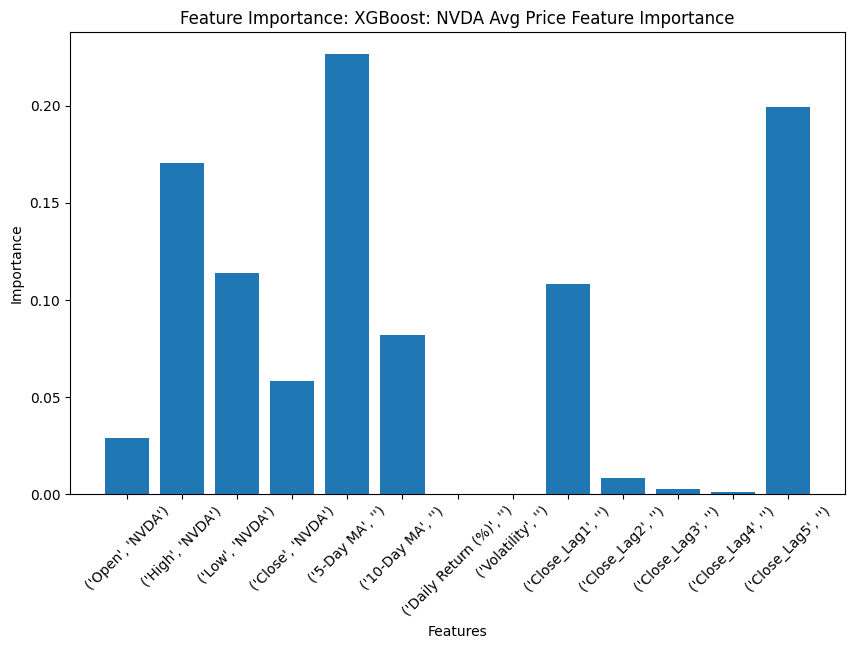

[*********************100%***********************]  1 of 1 completed

Removing the first row from preprocessed file: nvda_preprocessed.csv
First row removed and file saved back to nvda_preprocessed.csv

Processing NVDQ...
Raw data saved to nvdq_raw.csv
Calculating features...
Generating targets...
Preprocessed data saved to nvdq_preprocessed.csv


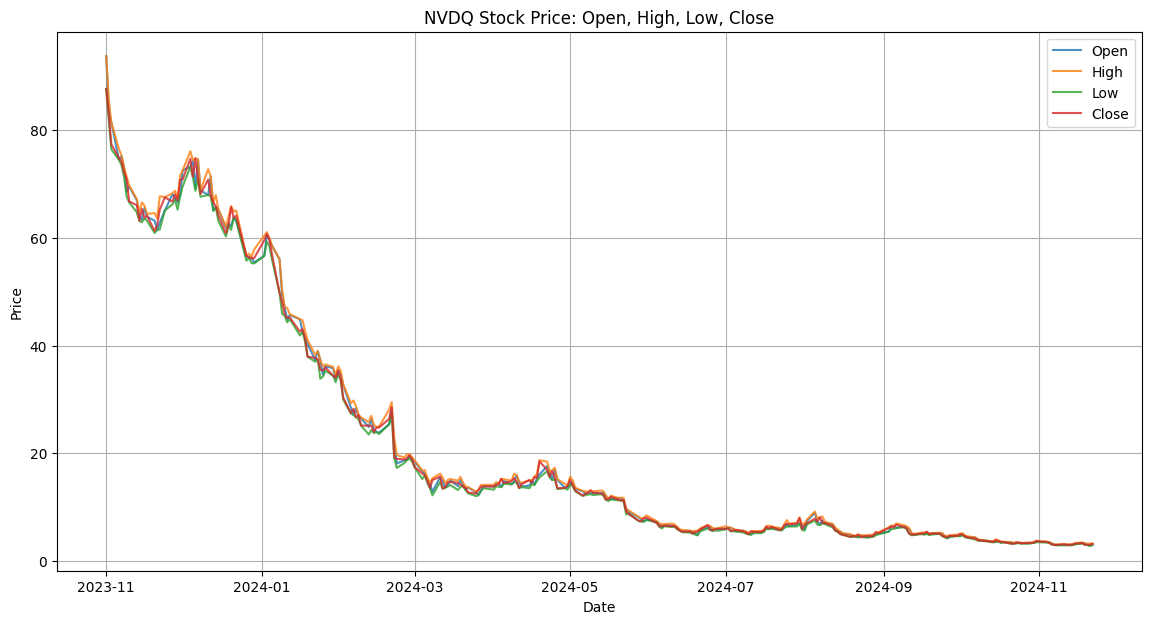


Training model for NVDQ - Max Price...
Training XGBoost model with tuned hyperparameters...
NVDQ Max Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvdq_max_xgboost_model.pkl


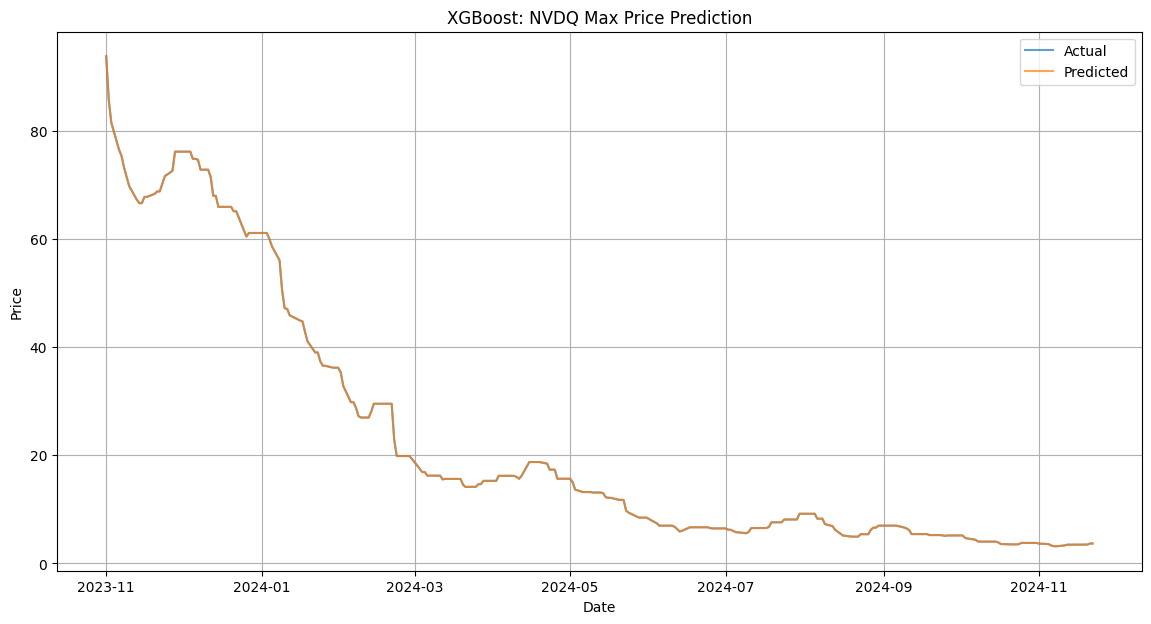

Plotting feature importance for NVDQ - Max Price...


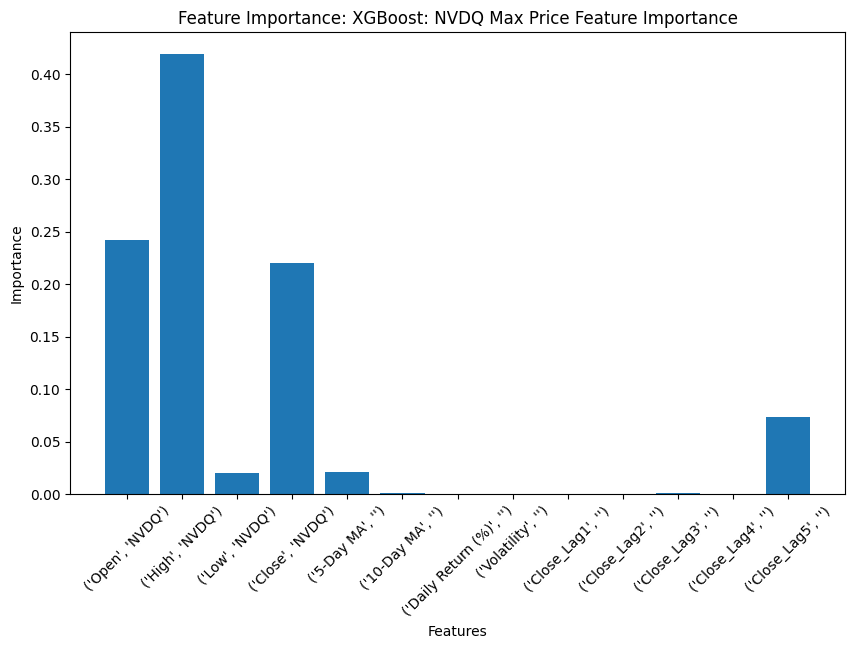


Training model for NVDQ - Min Price...
Training XGBoost model with tuned hyperparameters...
NVDQ Min Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvdq_min_xgboost_model.pkl


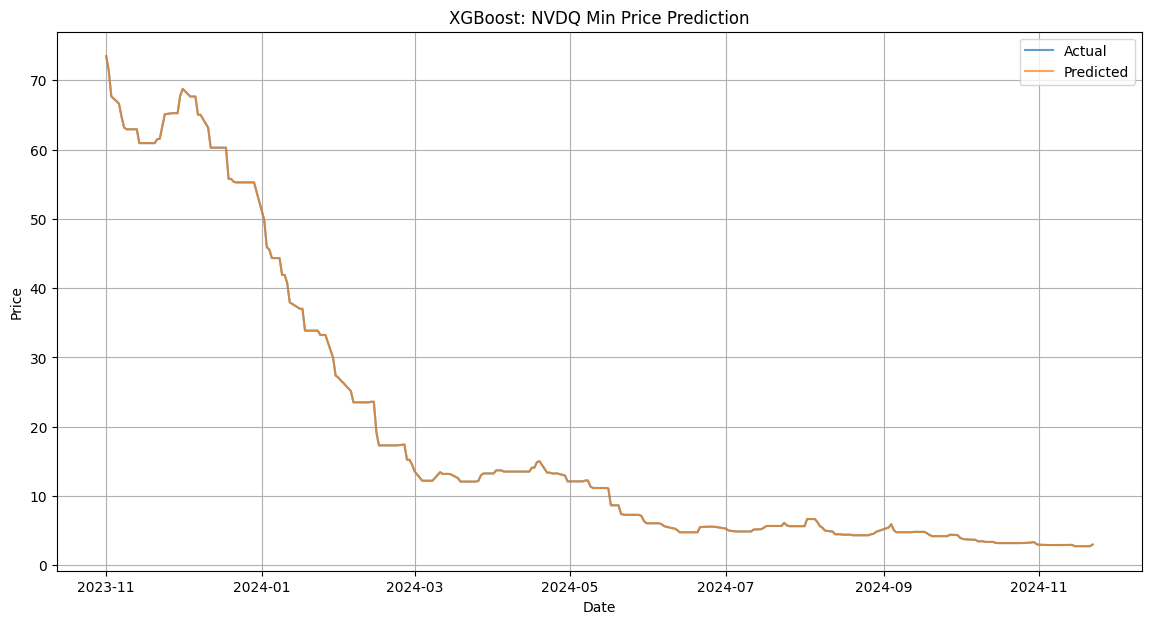

Plotting feature importance for NVDQ - Min Price...


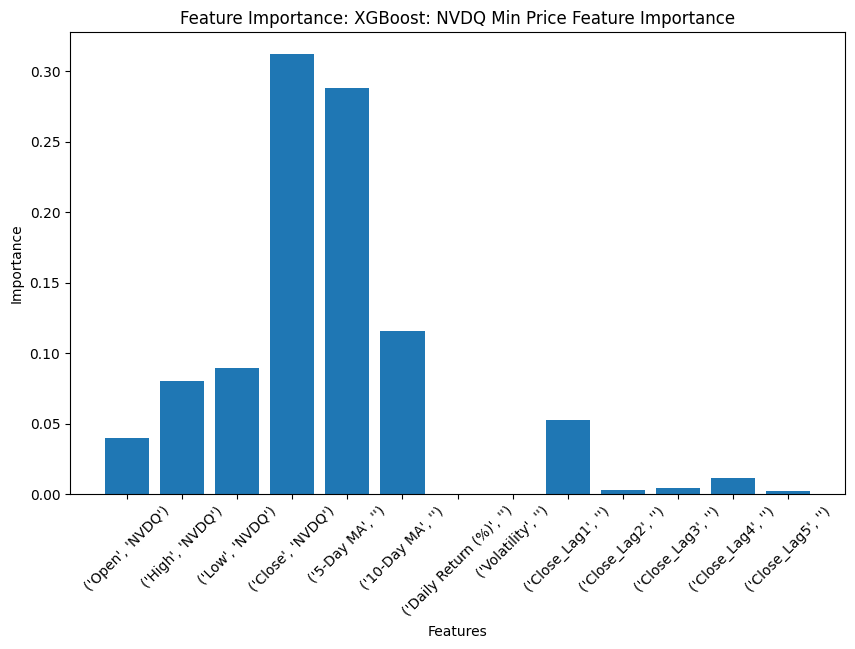


Training model for NVDQ - Avg Price...
Training XGBoost model with tuned hyperparameters...
NVDQ Avg Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvdq_avg_xgboost_model.pkl


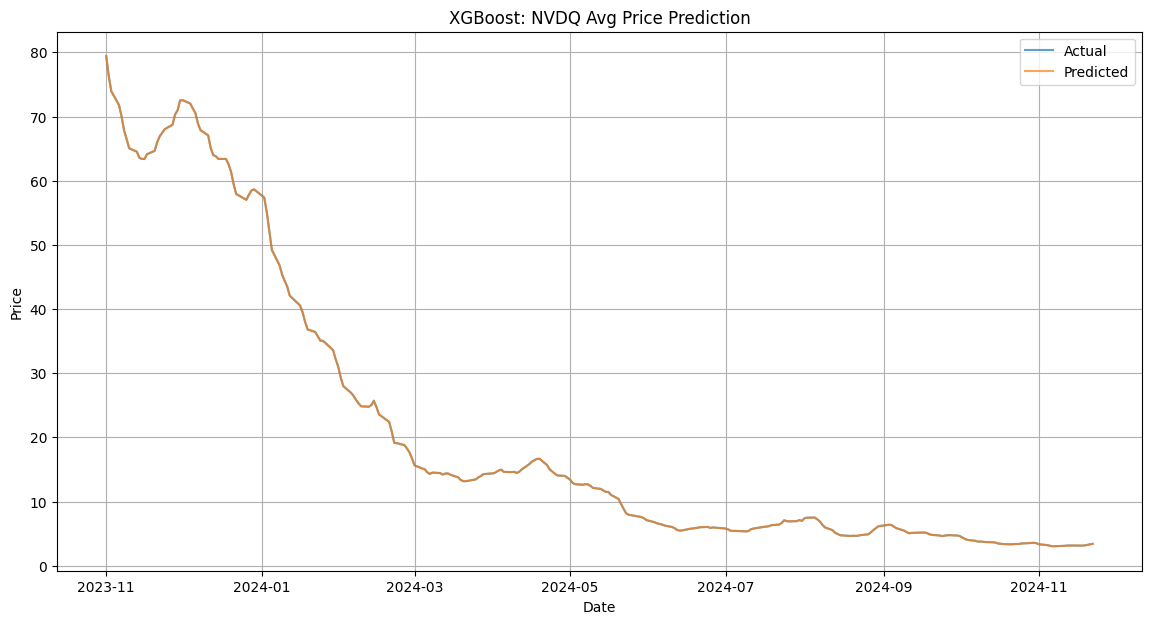

Plotting feature importance for NVDQ - Avg Price...


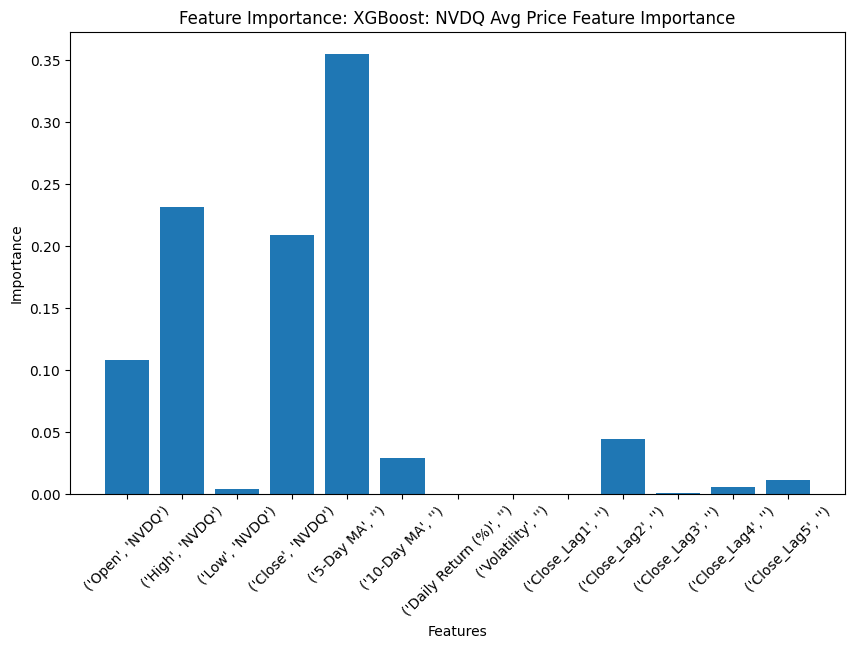

Removing the first row from preprocessed file: nvdq_preprocessed.csv
First row removed and file saved back to nvdq_preprocessed.csv


In [55]:
# Install XGBoost if needed
# !pip install xgboost

import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import joblib

# Step 1: Download Data
def download_data(ticker, start_date, end_date, save_raw=False):
    print(f"Downloading raw data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)

    # Reset index to ensure 'Date' is a column
    data.reset_index(inplace=True)

    # Drop rows with metadata in the first row (if Date is NaN or contains ticker symbol)
    if data.iloc[0].isnull().any() or ticker in data.iloc[0].values:
        print(f"Removing metadata row for {ticker}.")
        data = data.iloc[1:]

    # Save raw data
    if save_raw:
        raw_filename = f"{ticker.lower()}_raw.csv"
        data.to_csv(raw_filename, index=False)  # Save without the default index
        print(f"Raw data saved to {raw_filename}")

    return data

# Step 2: Feature Engineering
def calculate_features(data):
    print("Calculating features...")
    # Moving Averages
    data['5-Day MA'] = data['Close'].rolling(window=5).mean()
    data['10-Day MA'] = data['Close'].rolling(window=10).mean()

    # Daily Returns
    data['Daily Return (%)'] = data['Close'].pct_change() * 100

    # Volatility
    data['Volatility'] = (data['High'] - data['Low']) / data['Low'] * 100

    # Lag Features
    for lag in range(1, 6):  # 1 to 5 lag features
        data[f'Close_Lag{lag}'] = data['Close'].shift(lag)

    return data

# Step 3: Generate Targets
def generate_targets(data):
    print("Generating targets...")
    data['Target_Max'] = data['High'].rolling(window=5).max().shift(-4)
    data['Target_Min'] = data['Low'].rolling(window=5).min().shift(-4)
    data['Target_Avg'] = data['Close'].rolling(window=5).mean().shift(-4)
    return data

# Step 4: Train XGBoost Model with Tuned Hyperparameters
def train_xgboost(X, y):
    print("Training XGBoost model with tuned hyperparameters...")
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.1,    # Optimal learning rate
        max_depth=8,          # Optimal tree depth
        reg_lambda=1,         # Reduced regularization
        subsample=0.8,        # Subsample 80% of data
        colsample_bytree=0.9, # Use 90% of features per tree
        random_state=42
    )
    model.fit(X, y)
    return model

# Step 5: Evaluate Model
def evaluate_model(y_actual, y_pred, title):
    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    print(f"{title} - Mean Squared Error: {mse:.2f}, R2 Score: {r2:.2f}")
    return mse, r2

# Step 6: Feature Importance Plot
def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    cleaned_features = [str(f) for f in features]  # Ensure all features are strings
    plt.figure(figsize=(10, 6))
    plt.bar(cleaned_features, importance)
    plt.title(f"Feature Importance: {title}")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)
    plt.show()

# Step 7: Plot Results
def plot_results(dates, y_actual, y_pred, title):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_actual, label='Actual', alpha=0.7)
    plt.plot(dates, y_pred, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

# Step 8: Visualization - OHLC Actual Data
def plot_ohlc(data, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Open'], label='Open', alpha=0.8)
    plt.plot(data['Date'], data['High'], label='High', alpha=0.8)
    plt.plot(data['Date'], data['Low'], label='Low', alpha=0.8)
    plt.plot(data['Date'], data['Close'], label='Close', alpha=0.8)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Step 9: Remove First Row from Preprocessed File
def remove_first_row(preprocessed_filename):
    print(f"Removing the first row from preprocessed file: {preprocessed_filename}")
    data = pd.read_csv(preprocessed_filename)
    # Remove the first row explicitly
    data = data.iloc[1:]
    # Save the cleaned file back
    data.to_csv(preprocessed_filename, index=False)
    print(f"First row removed and file saved back to {preprocessed_filename}")
    return data

# Main Execution
if __name__ == "__main__":
    # Parameters
    tickers = ['NVDA', 'NVDQ']  # Two tickers
    start_date = '2020-01-01'
    end_date = '2024-12-01'
    # Features: Include ALL features
    features = ['Open', 'High', 'Low', 'Close', '5-Day MA', '10-Day MA',
                'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2',
                'Close_Lag3', 'Close_Lag4', 'Close_Lag5']

    for ticker in tickers:
        print(f"\nProcessing {ticker}...")

        # Step 1: Data Collection
        raw_data = download_data(ticker, start_date, end_date, save_raw=True)

        # Step 2: Feature Engineering
        data = calculate_features(raw_data)

        # Step 3: Generate Targets
        data = generate_targets(data)
        data.dropna(inplace=True)  # Drop NaN rows after target generation

        # Remove Ticker Column if Present
        if 'Ticker' in data.columns:
            data.drop(columns=['Ticker'], inplace=True)

        # Save Preprocessed Data
        preprocessed_filename = f"{ticker.lower()}_preprocessed.csv"
        data.to_csv(preprocessed_filename, index=False)
        print(f"Preprocessed data saved to {preprocessed_filename}")

        # Plot OHLC Data
        plot_ohlc(data, f'{ticker} Stock Price: Open, High, Low, Close')

        # Prepare Training Data
        X = data[features]
        targets = {'Target_Max': 'Max', 'Target_Min': 'Min', 'Target_Avg': 'Avg'}

        for target, label in targets.items():
            print(f"\nTraining model for {ticker} - {label} Price...")
            y = data[target]

            # Train Model
            model = train_xgboost(X, y)

            # Predict
            y_pred = model.predict(X)

            # Align Dates for Plotting
            y_actual = y
            y_pred = pd.Series(y_pred, index=y.index)

            # Evaluate
            mse, r2 = evaluate_model(y_actual, y_pred, f"{ticker} {label} Price Prediction")

            # Save Model
            model_filename = f"{ticker.lower()}_{label.lower()}_xgboost_model.pkl"
            joblib.dump(model, model_filename)
            print(f"Model saved as {model_filename}")

            # Plot Results
            plot_results(data['Date'], y_actual, y_pred, f"XGBoost: {ticker} {label} Price Prediction")

            # Plot Feature Importance
            print(f"Plotting feature importance for {ticker} - {label} Price...")
            plot_feature_importance(model, X.columns, f"XGBoost: {ticker} {label} Price Feature Importance")

        # Step 9: Remove first row from preprocessed file
        data = remove_first_row(preprocessed_filename)


Cleaner data training

[*********************100%***********************]  1 of 1 completed


Processing NVDA...
Raw data saved to nvda_raw.csv
Calculating features...
Generating targets...
Preprocessed data saved to nvda_preprocessed.csv
Removing the first row from preprocessed file: nvda_preprocessed.csv


First row removed, numerical columns ensured, and file saved back to nvda_preprocessed.csv


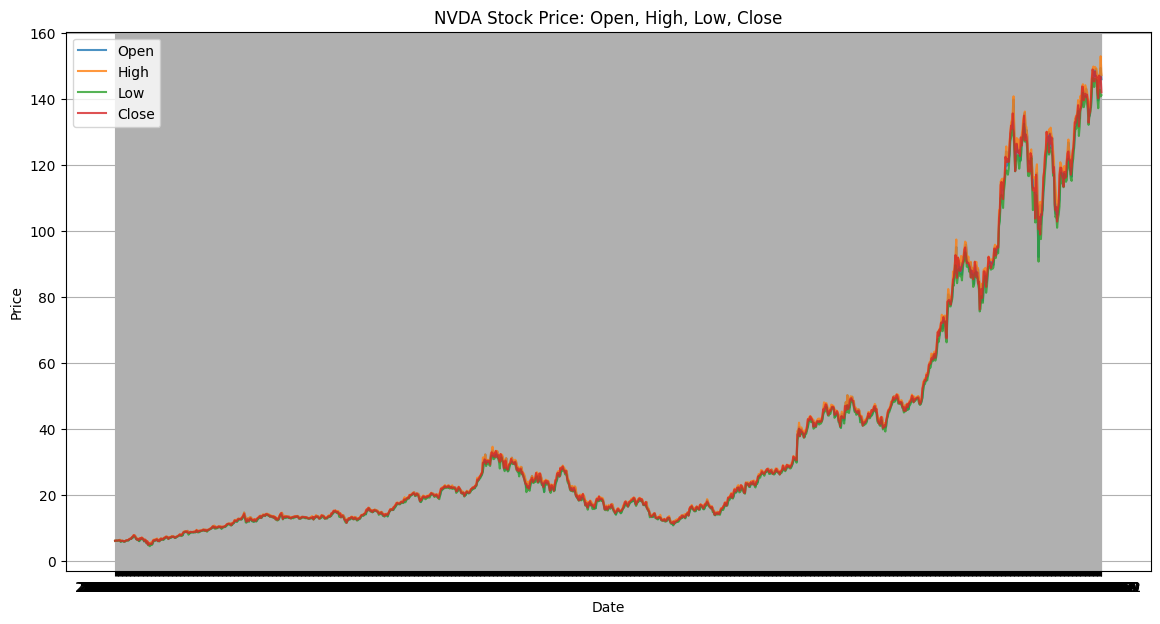


Training model for NVDA - Max Price...
Training XGBoost model with tuned hyperparameters...
NVDA Max Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvda_max_xgboost_model.pkl


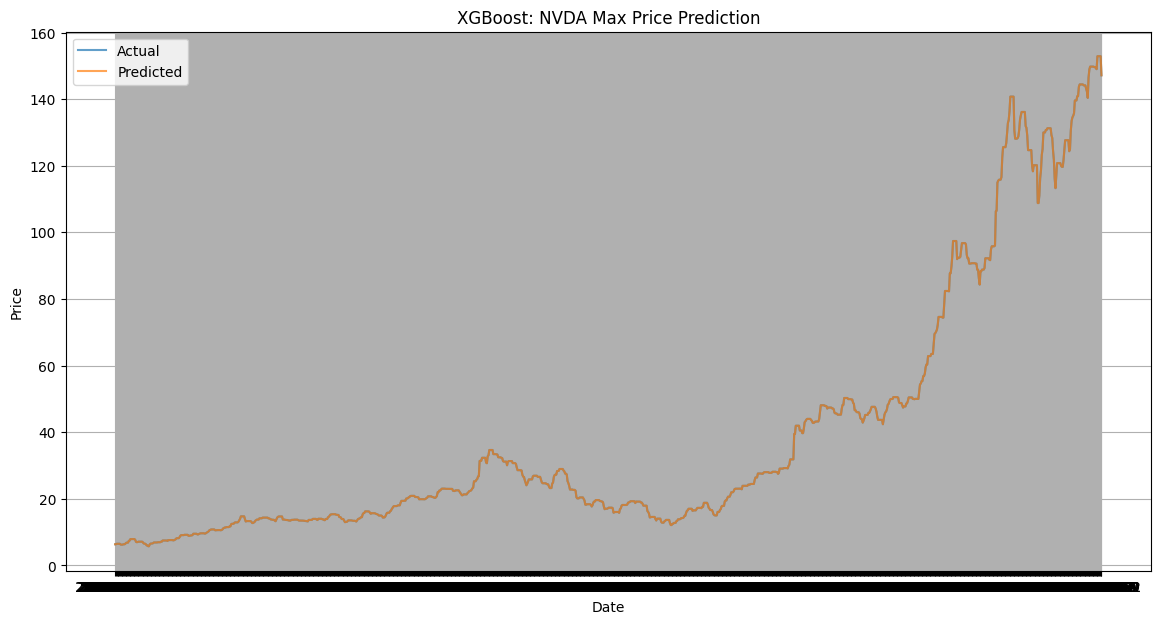

Plotting feature importance for NVDA - Max Price...


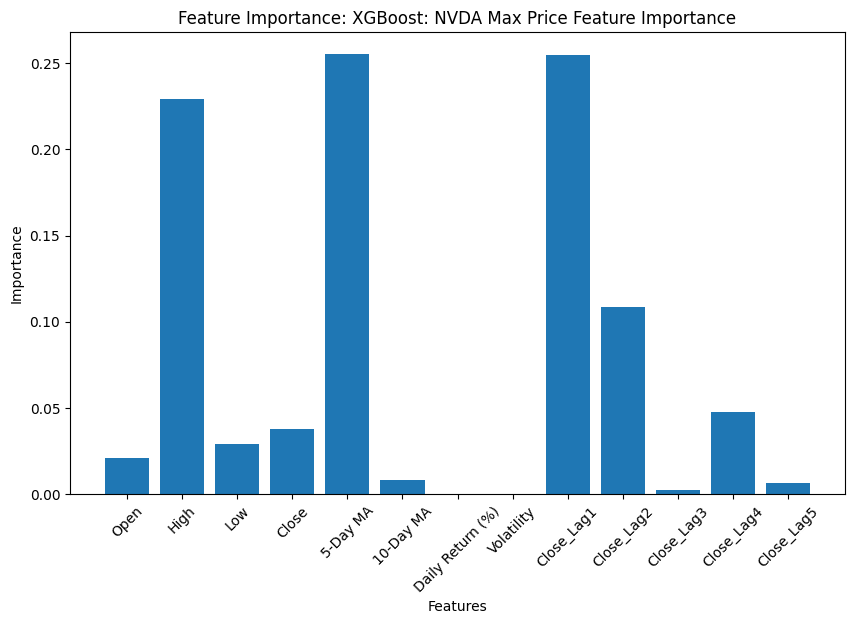


Training model for NVDA - Min Price...
Training XGBoost model with tuned hyperparameters...
NVDA Min Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvda_min_xgboost_model.pkl


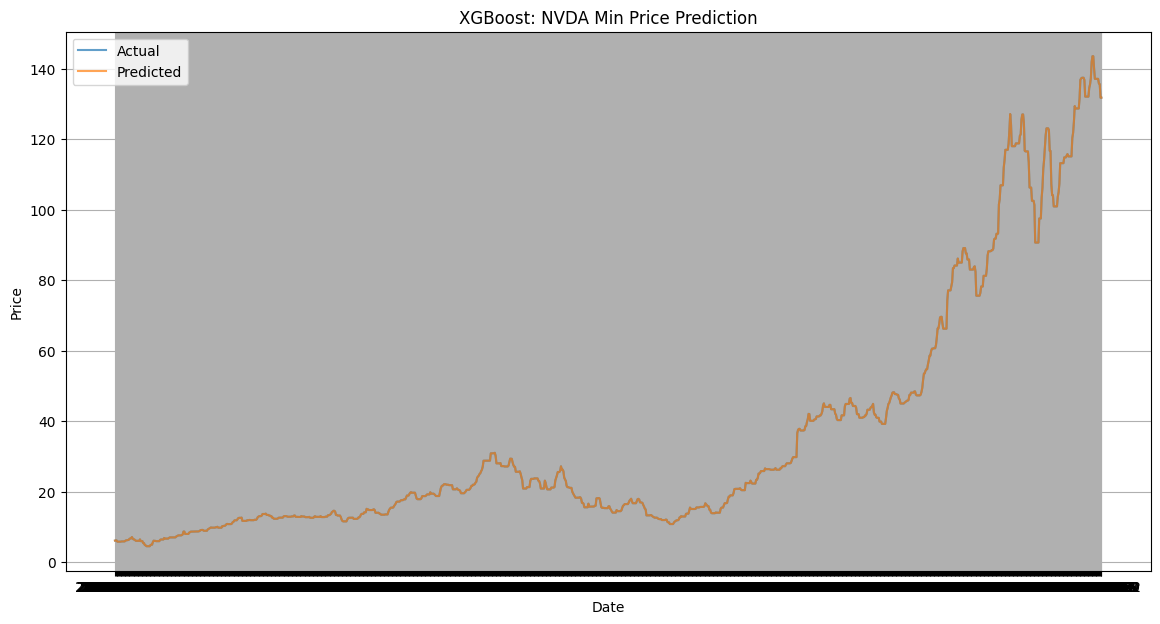

Plotting feature importance for NVDA - Min Price...


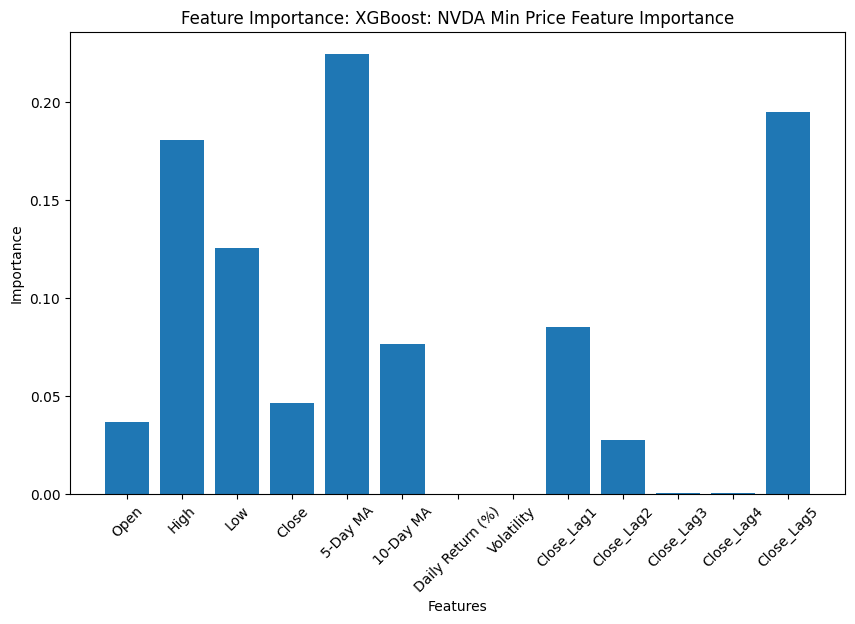


Training model for NVDA - Avg Price...
Training XGBoost model with tuned hyperparameters...
NVDA Avg Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvda_avg_xgboost_model.pkl


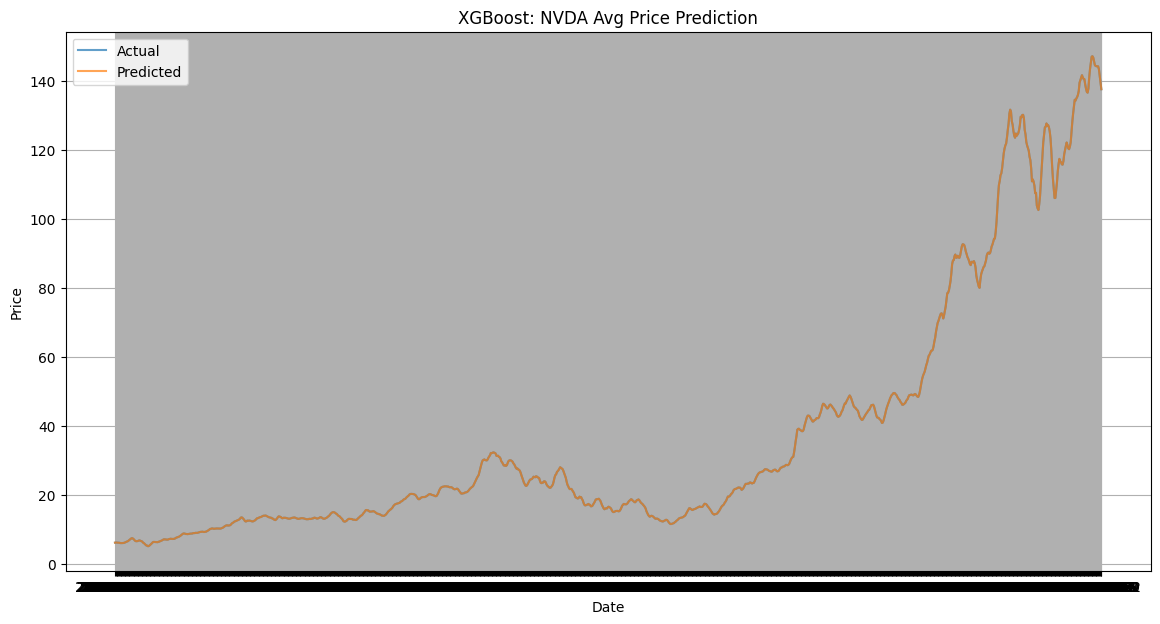

Plotting feature importance for NVDA - Avg Price...


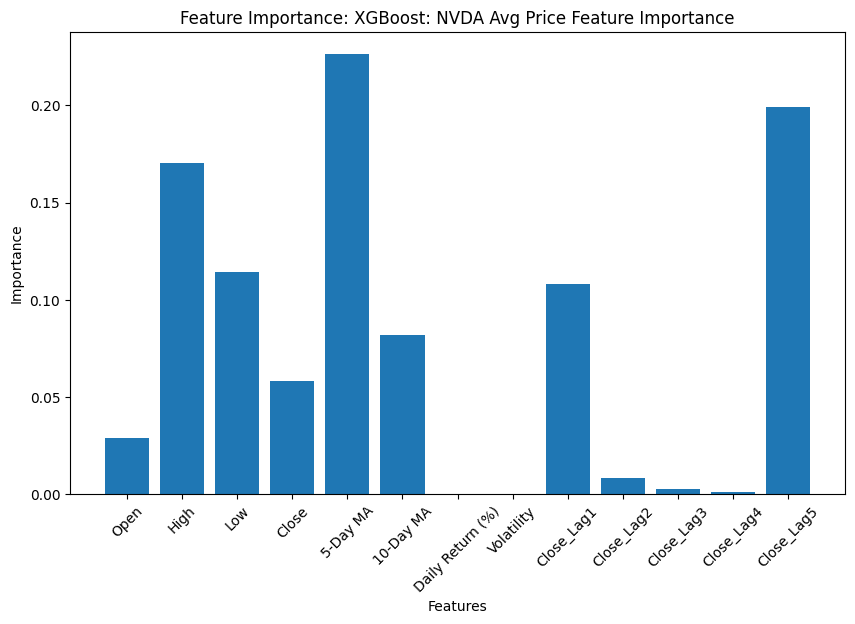

[*********************100%***********************]  1 of 1 completed


Processing NVDQ...
Raw data saved to nvdq_raw.csv
Calculating features...
Generating targets...
Preprocessed data saved to nvdq_preprocessed.csv
Removing the first row from preprocessed file: nvdq_preprocessed.csv
First row removed, numerical columns ensured, and file saved back to nvdq_preprocessed.csv


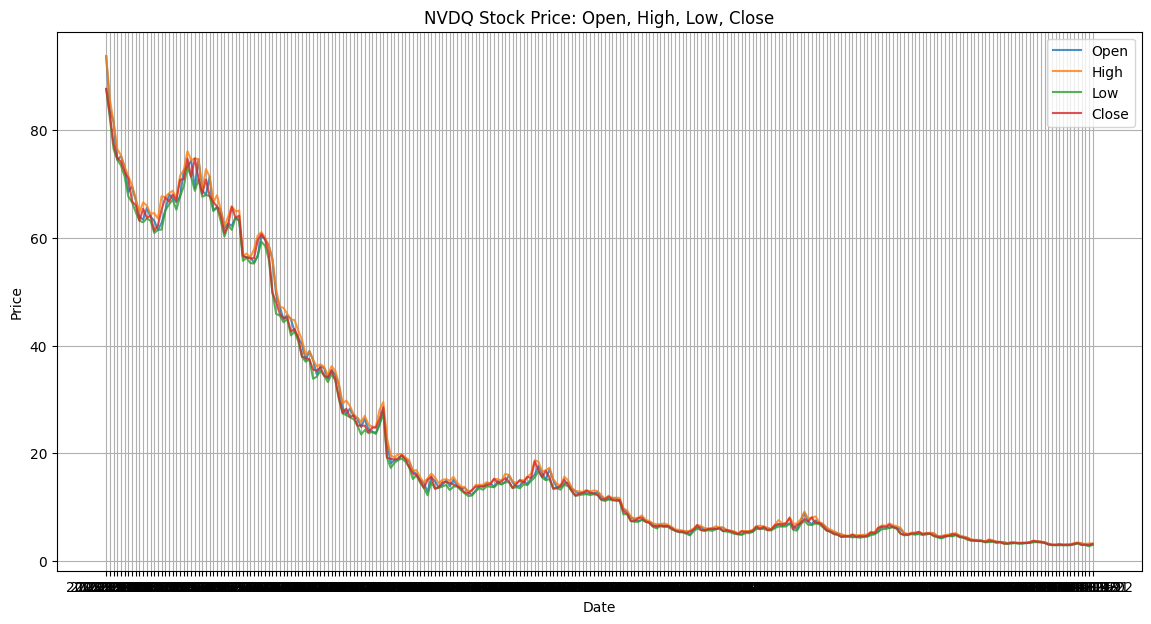


Training model for NVDQ - Max Price...
Training XGBoost model with tuned hyperparameters...
NVDQ Max Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvdq_max_xgboost_model.pkl


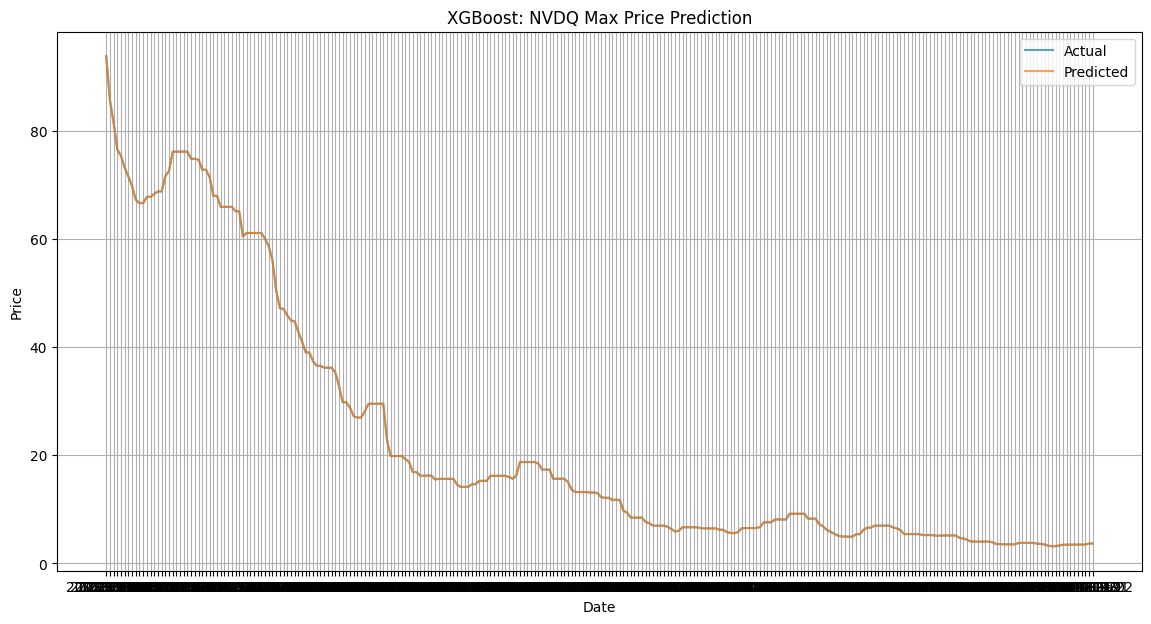

Plotting feature importance for NVDQ - Max Price...


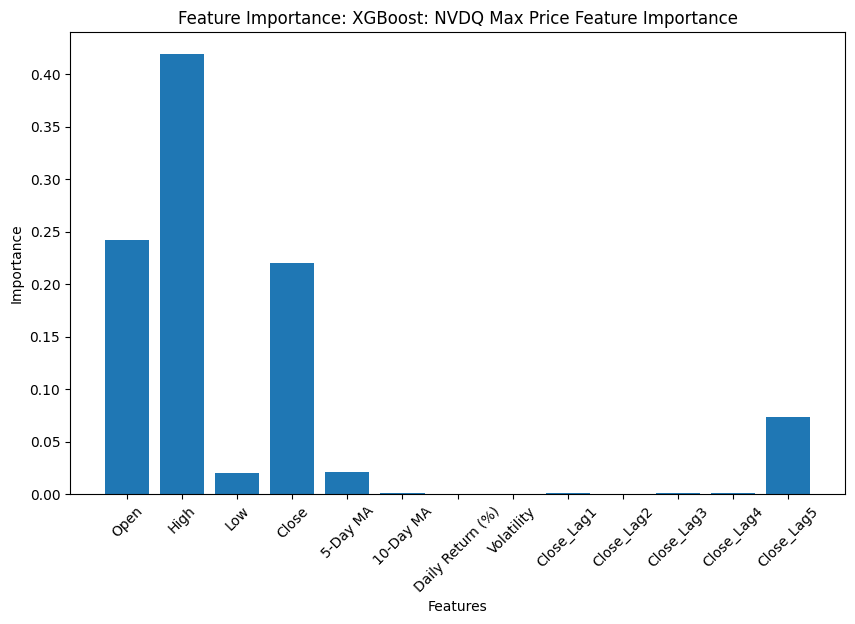


Training model for NVDQ - Min Price...
Training XGBoost model with tuned hyperparameters...
NVDQ Min Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvdq_min_xgboost_model.pkl


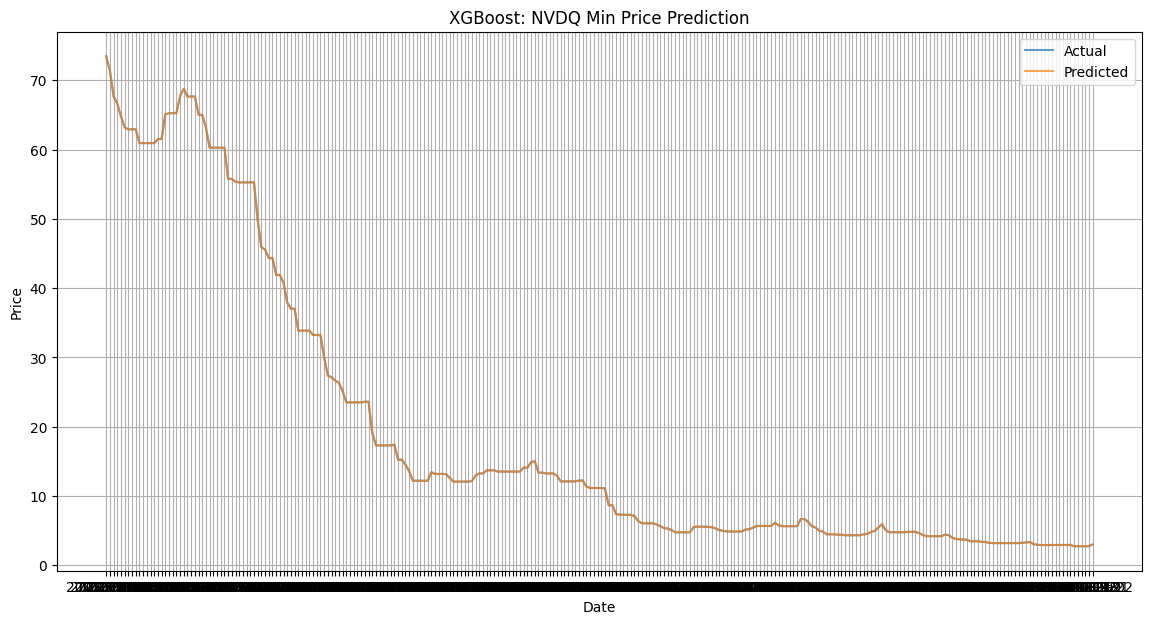

Plotting feature importance for NVDQ - Min Price...


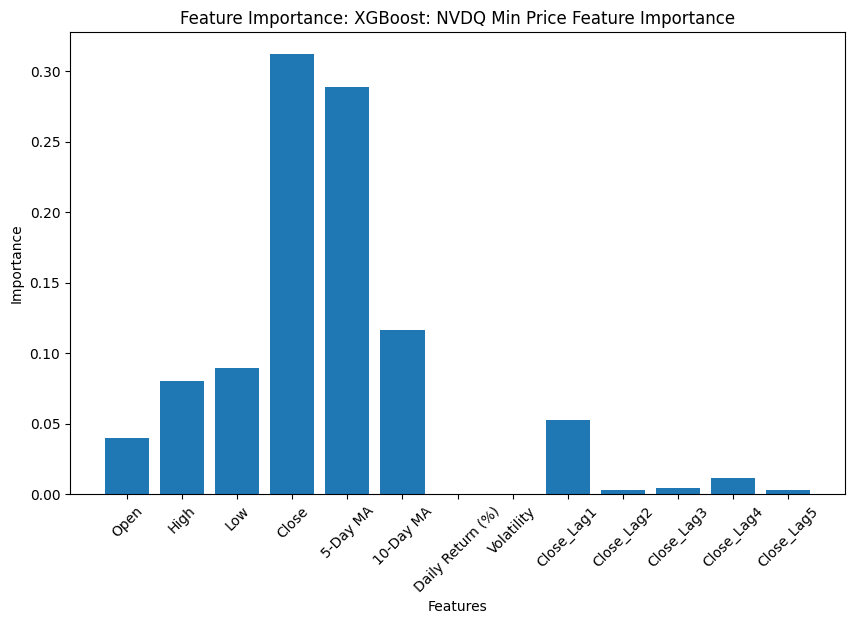


Training model for NVDQ - Avg Price...
Training XGBoost model with tuned hyperparameters...
NVDQ Avg Price Prediction - Mean Squared Error: 0.00, R2 Score: 1.00
Model saved as nvdq_avg_xgboost_model.pkl


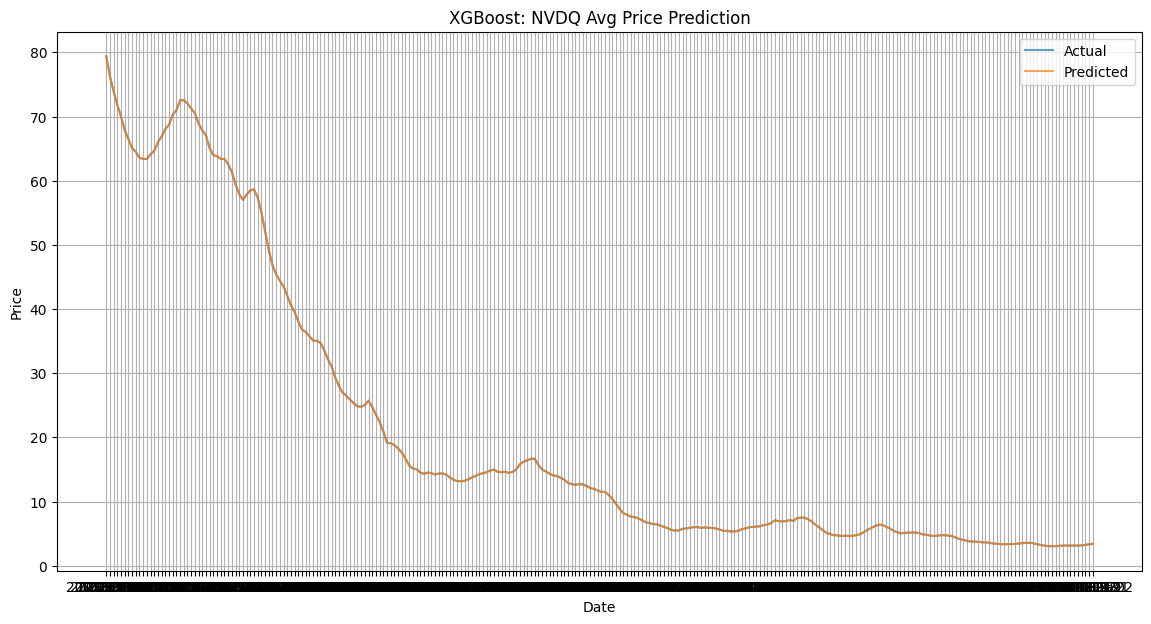

Plotting feature importance for NVDQ - Avg Price...


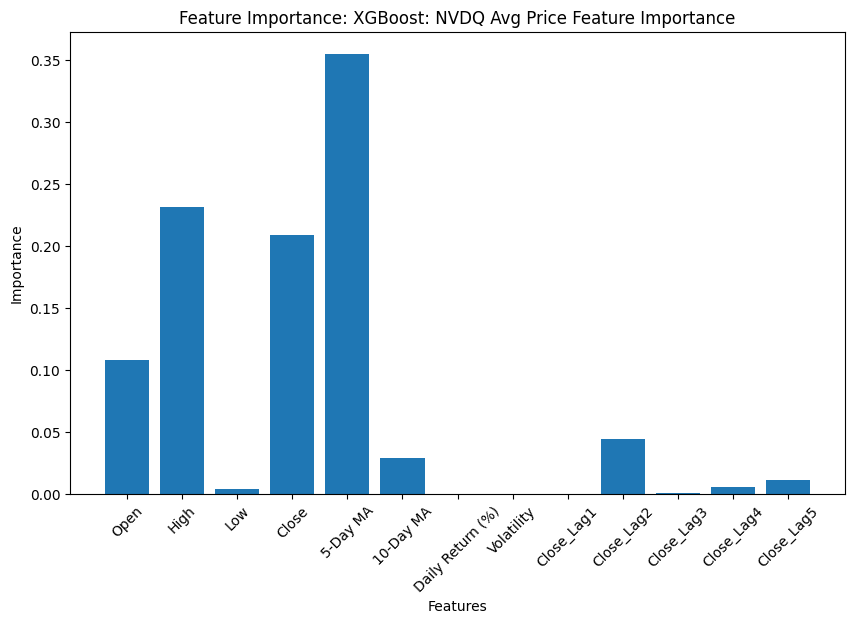

In [56]:
# Install XGBoost if needed
# !pip install xgboost

import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import joblib

# Step 1: Download Data
def download_data(ticker, start_date, end_date, save_raw=False):
    print(f"Downloading raw data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)

    # Reset index to ensure 'Date' is a column
    data.reset_index(inplace=True)

    # Drop rows with metadata in the first row (if Date is NaN or contains ticker symbol)
    if data.iloc[0].isnull().any() or ticker in data.iloc[0].values:
        print(f"Removing metadata row for {ticker}.")
        data = data.iloc[1:]

    # Save raw data
    if save_raw:
        raw_filename = f"{ticker.lower()}_raw.csv"
        data.to_csv(raw_filename, index=False)  # Save without the default index
        print(f"Raw data saved to {raw_filename}")

    return data

# Step 2: Feature Engineering
def calculate_features(data):
    print("Calculating features...")
    # Moving Averages
    data['5-Day MA'] = data['Close'].rolling(window=5).mean()
    data['10-Day MA'] = data['Close'].rolling(window=10).mean()

    # Daily Returns
    data['Daily Return (%)'] = data['Close'].pct_change() * 100

    # Volatility
    data['Volatility'] = (data['High'] - data['Low']) / data['Low'] * 100

    # Lag Features
    for lag in range(1, 6):  # 1 to 5 lag features
        data[f'Close_Lag{lag}'] = data['Close'].shift(lag)

    return data

# Step 3: Generate Targets
def generate_targets(data):
    print("Generating targets...")
    data['Target_Max'] = data['High'].rolling(window=5).max().shift(-4)
    data['Target_Min'] = data['Low'].rolling(window=5).min().shift(-4)
    data['Target_Avg'] = data['Close'].rolling(window=5).mean().shift(-4)
    return data

# Step 4: Train XGBoost Model with Tuned Hyperparameters
def train_xgboost(X, y):
    print("Training XGBoost model with tuned hyperparameters...")
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.1,    # Optimal learning rate
        max_depth=8,          # Optimal tree depth
        reg_lambda=1,         # Reduced regularization
        subsample=0.8,        # Subsample 80% of data
        colsample_bytree=0.9, # Use 90% of features per tree
        random_state=42
    )
    model.fit(X, y)
    return model

# Step 5: Evaluate Model
def evaluate_model(y_actual, y_pred, title):
    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    print(f"{title} - Mean Squared Error: {mse:.2f}, R2 Score: {r2:.2f}")
    return mse, r2

# Step 6: Feature Importance Plot
def plot_feature_importance(model, features, title):
    importance = model.feature_importances_
    cleaned_features = [str(f) for f in features]  # Ensure all features are strings
    plt.figure(figsize=(10, 6))
    plt.bar(cleaned_features, importance)
    plt.title(f"Feature Importance: {title}")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)
    plt.show()

# Step 7: Plot Results
def plot_results(dates, y_actual, y_pred, title):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_actual, label='Actual', alpha=0.7)
    plt.plot(dates, y_pred, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()

# Step 8: Visualization - OHLC Actual Data
def plot_ohlc(data, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Open'], label='Open', alpha=0.8)
    plt.plot(data['Date'], data['High'], label='High', alpha=0.8)
    plt.plot(data['Date'], data['Low'], label='Low', alpha=0.8)
    plt.plot(data['Date'], data['Close'], label='Close', alpha=0.8)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Step 9: Remove First Row from Preprocessed File
def remove_first_row(preprocessed_filename):
    print(f"Removing the first row from preprocessed file: {preprocessed_filename}")
    data = pd.read_csv(preprocessed_filename)
    # Remove the first row explicitly
    data = data.iloc[1:]

    # Ensure numerical columns are correctly typed
    numeric_columns = ['Open', 'High', 'Low', 'Close', '5-Day MA', '10-Day MA',
                       'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2',
                       'Close_Lag3', 'Close_Lag4', 'Close_Lag5', 'Target_Max', 'Target_Min', 'Target_Avg']
    for col in numeric_columns:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

    # Drop rows with NaN values after conversion
    data.dropna(inplace=True)

    # Save the cleaned file back
    data.to_csv(preprocessed_filename, index=False)
    print(f"First row removed, numerical columns ensured, and file saved back to {preprocessed_filename}")
    return data

# Main Execution
if __name__ == "__main__":
    # Parameters
    tickers = ['NVDA', 'NVDQ']  # Two tickers
    start_date = '2020-01-01'
    end_date = '2024-12-01'
    # Features: Include ALL features
    features = ['Open', 'High', 'Low', 'Close', '5-Day MA', '10-Day MA',
                'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2',
                'Close_Lag3', 'Close_Lag4', 'Close_Lag5']

    for ticker in tickers:
        print(f"\nProcessing {ticker}...")

        # Step 1: Data Collection
        raw_data = download_data(ticker, start_date, end_date, save_raw=True)

        # Step 2: Feature Engineering
        data = calculate_features(raw_data)

        # Step 3: Generate Targets
        data = generate_targets(data)
        data.dropna(inplace=True)  # Drop NaN rows after target generation

        # Remove Ticker Column if Present
        if 'Ticker' in data.columns:
            data.drop(columns=['Ticker'], inplace=True)

        # Save Preprocessed Data
        preprocessed_filename = f"{ticker.lower()}_preprocessed.csv"
        data.to_csv(preprocessed_filename, index=False)
        print(f"Preprocessed data saved to {preprocessed_filename}")

        # Step 9: Remove first row from preprocessed file before training
        data = remove_first_row(preprocessed_filename)

        # Plot OHLC Data
        plot_ohlc(data, f'{ticker} Stock Price: Open, High, Low, Close')

        # Prepare Training Data
        X = data[features]
        targets = {'Target_Max': 'Max', 'Target_Min': 'Min', 'Target_Avg': 'Avg'}

        for target, label in targets.items():
            print(f"\nTraining model for {ticker} - {label} Price...")
            y = data[target]

            # Train Model
            model = train_xgboost(X, y)

            # Predict
            y_pred = model.predict(X)

            # Align Dates for Plotting
            y_actual = y
            y_pred = pd.Series(y_pred, index=y.index)

            # Evaluate
            mse, r2 = evaluate_model(y_actual, y_pred, f"{ticker} {label} Price Prediction")

            # Save Model
            model_filename = f"{ticker.lower()}_{label.lower()}_xgboost_model.pkl"
            joblib.dump(model, model_filename)
            print(f"Model saved as {model_filename}")

            # Plot Results
            plot_results(data['Date'], y_actual, y_pred, f"XGBoost: {ticker} {label} Price Prediction")

            # Plot Feature Importance
            print(f"Plotting feature importance for {ticker} - {label} Price...")
            plot_feature_importance(model, X.columns, f"XGBoost: {ticker} {label} Price Feature Importance")


Hyperparameter Tuning for Model

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import pandas as pd

# Load preprocessed data
preprocessed_file = "nvda_preprocessed.csv"  # have been tested for nvdq as well
data = pd.read_csv(preprocessed_file)

# Define features and target
features = ['Open', 'High', 'Low', 'Close', '5-Day MA', '10-Day MA',
            'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2',
            'Close_Lag3', 'Close_Lag4', 'Close_Lag5']
X = data[features]
y = data['Target_Max']  # Replace with 'Target_Min' or 'Target_Avg' as needed

# Ensure numeric data and drop rows with NaN values
X = X.apply(pd.to_numeric, errors='coerce').dropna()
y = y[X.index].dropna()

# Hyperparameter tuning function
def tune_xgboost(X_train, y_train):
    print("Tuning XGBoost model...")

    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [500, 1000, 1500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [4, 6, 8],
        'reg_lambda': [1, 2, 3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Initialize XGBoost model
    model = XGBRegressor(random_state=42)

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        scoring='r2',
        random_state=42,
        verbose=1,
        n_jobs=-1
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Print best parameters
    print(f"Best Parameters: {random_search.best_params_}")
    return random_search.best_estimator_

# Run hyperparameter tuning
best_model = tune_xgboost(X, y)


Tuning XGBoost model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


Evaluation of Models for Today as '2024-09-22', '2024-10-20', '2024-11-17'

Loading preprocessed data from nvda_preprocessed.csv...
Data loaded with columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', '5-Day MA', '10-Day MA', 'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag4', 'Close_Lag5', 'Target_Max', 'Target_Min', 'Target_Avg']
Loading models for NVDA...

NVDA: Predicting from 2024-09-23...
NVDA High - MSE: 13.23, MAPE: 2.47%
NVDA Low  - MSE: 74.35, MAPE: 6.43%
NVDA Avg  - MSE: 42.33, MAPE: 4.56%

Prediction Results Table:
        Date  Predicted High  Actual High  Diff High  Error% High  \
0 2024-09-24      127.669998   121.800003   5.869995     4.819372   
1 2024-09-25      125.190002   124.940002   0.250000     0.200096   
2 2024-09-26      123.260002   127.669998  -4.409996     3.454215   
3 2024-09-27      121.029999   124.029999  -3.000000     2.418770   
4 2024-09-30      119.709999   121.500000  -1.790001     1.473252   

   Predicted Low  Actual Low   Diff Low  Error% Low  Predicted Avg  \
0     1

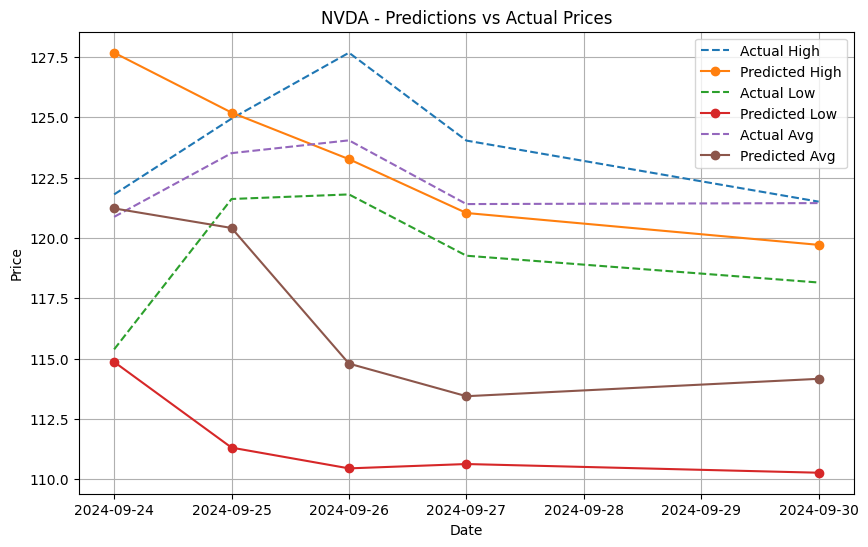


NVDA: Predicting from 2024-10-21...
NVDA High - MSE: 3.95, MAPE: 1.11%
NVDA Low  - MSE: 55.93, MAPE: 4.99%
NVDA Avg  - MSE: 7.14, MAPE: 1.67%

Prediction Results Table:
        Date  Predicted High  Actual High  Diff High  Error% High  \
0 2024-10-22      144.419998   144.419998   0.000000     0.000000   
1 2024-10-23      145.570007   142.429993   3.140015     2.204602   
2 2024-10-24      144.149994   141.350006   2.799988     1.980890   
3 2024-10-25      142.880005   144.130005  -1.250000     0.867273   
4 2024-10-28      143.839996   143.139999   0.699997     0.489030   

   Predicted Low  Actual Low   Diff Low  Error% Low  Predicted Avg  \
0     137.460007  141.779999  -4.319992    3.046969     141.759995   
1     133.589996  137.460007  -3.870010    2.815372     138.940002   
2     131.809998  138.460007  -6.650009    4.802838     137.850006   
3     130.710007  140.800003 -10.089996    7.166190     137.070007   
4     130.050003  140.050003 -10.000000    7.140307     138.19000

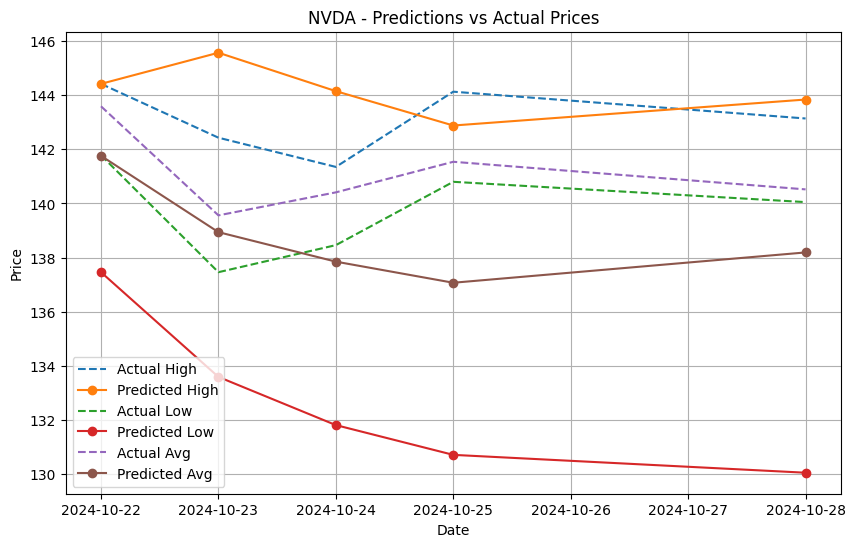


NVDA: Predicting from 2024-11-18...
NVDA High - MSE: 18.20, MAPE: 2.56%
NVDA Low  - MSE: 83.14, MAPE: 6.13%
NVDA Avg  - MSE: 35.59, MAPE: 3.69%

Prediction Results Table:
        Date  Predicted High  Actual High  Diff High  Error% High  \
0 2024-11-19      152.889999   147.130005   5.759995     3.914901   
1 2024-11-20      149.139999   147.559998   1.580002     1.070752   
2 2024-11-21      147.250000   152.889999  -5.639999     3.688926   
3 2024-11-22      144.850006   147.160004  -2.309998     1.569718   

   Predicted Low  Actual Low   Diff Low  Error% Low  Predicted Avg  \
0     137.149994  140.990005  -3.840012    2.723606     144.330002   
1     132.110001  142.729996 -10.619995    7.440619     141.759995   
2     130.610001  140.699997 -10.089996    7.171284     137.029999   
3     130.940002  141.100006 -10.160004    7.200569     136.929993   

   Actual Avg  Diff Avg  Error% Avg  
0  147.009995 -2.679993    1.823000  
1  145.889999 -4.130005    2.830903  
2  146.669998 -9.

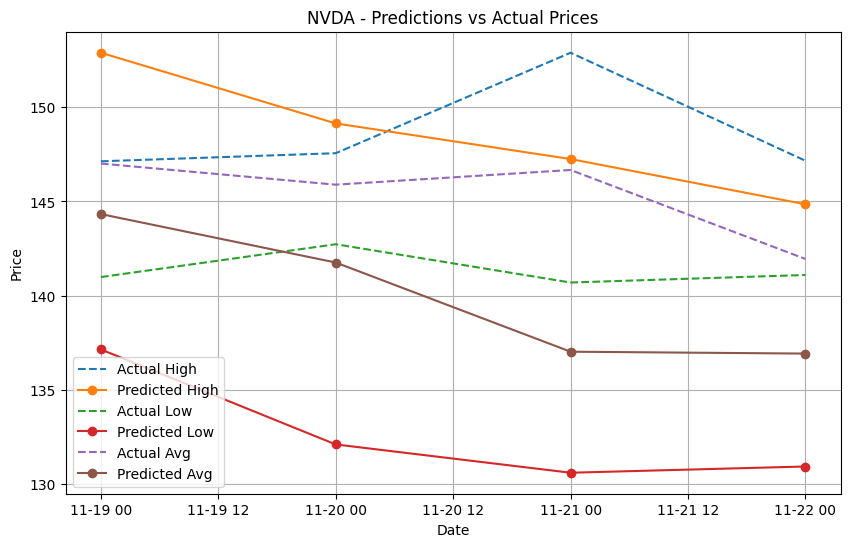

Loading preprocessed data from nvdq_preprocessed.csv...
Data loaded with columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', '5-Day MA', '10-Day MA', 'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag4', 'Close_Lag5', 'Target_Max', 'Target_Min', 'Target_Avg']
Loading models for NVDQ...

NVDQ: Predicting from 2024-09-23...
NVDQ High - MSE: 1.60, MAPE: 23.89%
NVDQ Low  - MSE: 0.06, MAPE: 4.17%
NVDQ Avg  - MSE: 0.49, MAPE: 13.18%

Prediction Results Table:
        Date  Predicted High  Actual High  Diff High  Error% High  \
0 2024-09-24            5.25        5.210      0.040     0.767754   
1 2024-09-25            5.99        4.660      1.330    28.540772   
2 2024-09-26            6.13        4.645      1.485    31.969863   
3 2024-09-27            6.35        4.820      1.530    31.742732   
4 2024-09-30            6.22        4.920      1.300    26.422758   

   Predicted Low  Actual Low  Diff Low  Error% Low  Predicted Avg  Actual Avg 

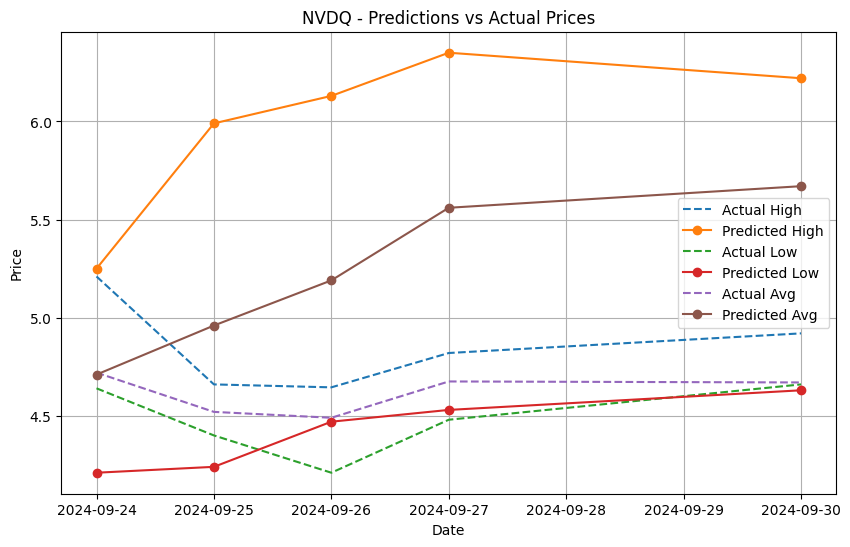


NVDQ: Predicting from 2024-10-21...
NVDQ High - MSE: 0.04, MAPE: 5.33%
NVDQ Low  - MSE: 0.05, MAPE: 5.90%
NVDQ Avg  - MSE: 0.01, MAPE: 2.22%

Prediction Results Table:
        Date  Predicted High  Actual High  Diff High  Error% High  \
0 2024-10-22            3.53        3.330      0.200     6.006008   
1 2024-10-23            3.64        3.525      0.115     3.262412   
2 2024-10-24            3.59        3.490      0.100     2.865327   
3 2024-10-25            3.61        3.370      0.240     7.121662   
4 2024-10-28            3.66        3.408      0.252     7.394369   

   Predicted Low  Actual Low  Diff Low  Error% Low  Predicted Avg  Actual Avg  \
0           3.21       3.210     0.000    0.000000           3.33       3.250   
1           3.06       3.305    -0.245    7.413014           3.31       3.430   
2           3.04       3.340    -0.300    8.982035           3.28       3.395   
3           3.03       3.210    -0.180    5.607479           3.33       3.330   
4          

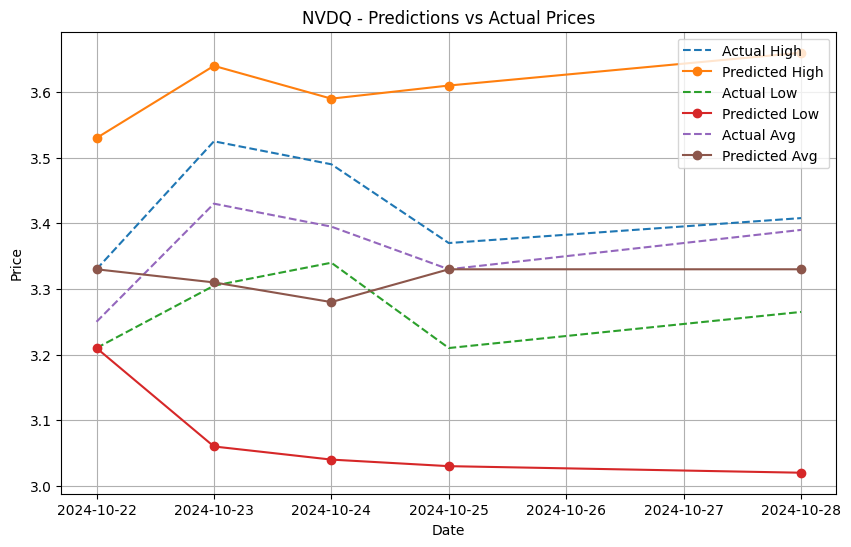


NVDQ: Predicting from 2024-11-18...
NVDQ High - MSE: 0.06, MAPE: 7.71%
NVDQ Low  - MSE: 0.03, MAPE: 5.07%
NVDQ Avg  - MSE: 0.03, MAPE: 4.69%

Prediction Results Table:
        Date  Predicted High  Actual High  Diff High  Error% High  \
0 2024-11-19            3.47         3.29       0.18     5.471127   
1 2024-11-20            3.45         3.18       0.27     8.490565   
2 2024-11-21            3.52         3.27       0.25     7.645260   
3 2024-11-22            3.55         3.25       0.30     9.230768   

   Predicted Low  Actual Low  Diff Low  Error% Low  Predicted Avg  Actual Avg  \
0           2.76       3.000    -0.240    8.000000           3.13       3.015   
1           2.85       2.992    -0.142    4.745996           3.21       3.060   
2           2.83       2.760     0.070    2.536229           3.29       3.020   
3           2.85       3.000    -0.150    5.000003           3.25       3.215   

   Diff Avg  Error% Avg  
0     0.115    3.814262  
1     0.150    4.901964  
2

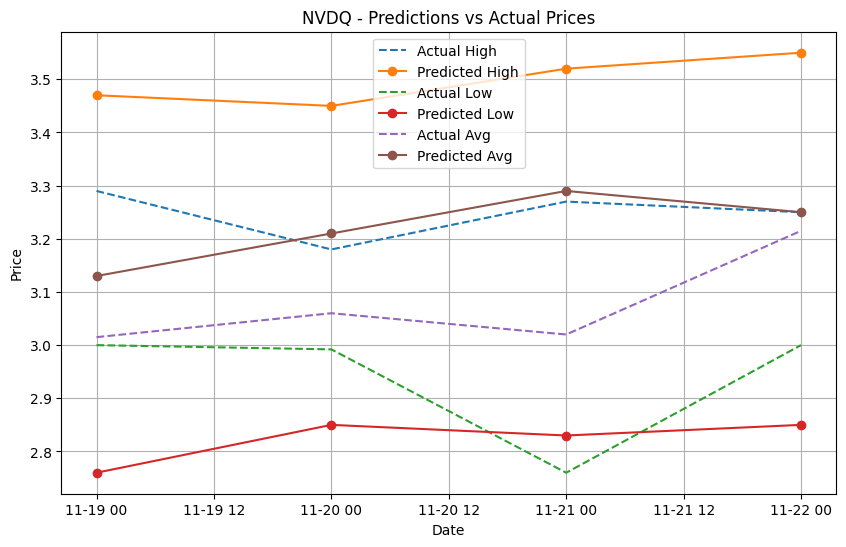

In [57]:
# Install Required Libraries if needed
# !pip install xgboost pandas matplotlib joblib

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from sklearn.metrics import mean_squared_error, r2_score

# Global Features List (matches what models expect)
FEATURES = ['Open', 'High', 'Low', 'Close', '5-Day MA', '10-Day MA',
            'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2',
            'Close_Lag3', 'Close_Lag4', 'Close_Lag5']

# Step 1: Load Preprocessed Data
def load_preprocessed_csv(file_path):
    print(f"Loading preprocessed data from {file_path}...")
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    print(f"Data loaded with columns: {list(df.columns)}")
    return df

# Step 2: Load Models
def load_models(ticker):
    """
    Load the trained XGBoost models for Max, Min, and Avg prices.
    """
    print(f"Loading models for {ticker}...")
    model_max = joblib.load(f"{ticker.lower()}_max_xgboost_model.pkl")
    model_min = joblib.load(f"{ticker.lower()}_min_xgboost_model.pkl")
    model_avg = joblib.load(f"{ticker.lower()}_avg_xgboost_model.pkl")
    return model_max, model_min, model_avg

# Step 3: Predict the Next 5 Days
def predict_next_5_days(models, X_current):
    """
    Predict the next 5 business days' prices starting immediately after the input date.
    """
    max_model, min_model, avg_model = models
    predictions = {'Date': [], 'Predicted High': [], 'Predicted Low': [], 'Predicted Avg': []}

    current_date = X_current.index[-1] + BDay(1)

    for _ in range(5):
        predictions['Date'].append(current_date.date())

        # Prepare input features: Ensure all required features are passed
        X_array = X_current[FEATURES].to_numpy()

        # Predict prices
        max_price = max_model.predict(X_array)[0]
        min_price = min_model.predict(X_array)[0]
        avg_price = avg_model.predict(X_array)[0]

        predictions['Predicted High'].append(round(max_price, 2))
        predictions['Predicted Low'].append(round(min_price, 2))
        predictions['Predicted Avg'].append(round(avg_price, 2))

        # Update features for the next day's prediction
        new_features = X_current.iloc[-1].copy()
        new_features['Close'] = avg_price
        new_features['5-Day MA'] = np.mean(pd.concat([X_current['Close'].tail(4), pd.Series(avg_price)]))
        new_features['10-Day MA'] = np.mean(pd.concat([X_current['Close'].tail(9), pd.Series(avg_price)]))
        new_features['Daily Return (%)'] = ((avg_price - X_current['Close'].iloc[-1]) / X_current['Close'].iloc[-1]) * 100
        new_features['Volatility'] = (max_price - min_price) / min_price * 100
        new_features['Close_Lag1'] = X_current['Close'].iloc[-1]
        new_features['Close_Lag2'] = X_current['Close_Lag1'].iloc[-1]
        new_features['Close_Lag3'] = X_current['Close_Lag2'].iloc[-1]
        new_features['Close_Lag4'] = X_current['Close_Lag3'].iloc[-1]
        new_features['Close_Lag5'] = X_current['Close_Lag4'].iloc[-1]

        # Append and update the feature set
        X_current = pd.concat([X_current, pd.DataFrame([new_features])]).iloc[1:]
        current_date += BDay(1)

    return pd.DataFrame(predictions)

# Step 4: Evaluate Predictions
def evaluate_predictions(dates_to_predict, data, models, ticker):
    """
    Evaluate predictions against actual values and display metrics.
    """
    for date in dates_to_predict:
        date = pd.Timestamp(date)

        # Increment date to the very next day (irrespective of business/non-business)
        next_day = date + pd.Timedelta(days=1)

        # Ensure next_day is within the dataset
        if next_day not in data.index:
            next_day = data.index[data.index > date][0]  # Find the next available date in index

        print(f"\n{ticker}: Predicting from {next_day.date()}...")

        # Prepare input data
        X_current = data.loc[[next_day], FEATURES]  # Ensure the full feature set is used

        # Predict the next 5 days
        predictions = predict_next_5_days(models, X_current)

        # Convert predictions['Date'] to datetime64 to match data.index
        predictions['Date'] = pd.to_datetime(predictions['Date'])

        # Fetch Actual Values
        actual_values = data.loc[data.index.isin(predictions['Date']), ['High', 'Low', 'Close']]
        actual_values.rename(columns={'High': 'Actual High', 'Low': 'Actual Low', 'Close': 'Actual Avg'}, inplace=True)

        # Merge predictions with actual values
        combined = predictions.merge(actual_values, left_on='Date', right_index=True)
        combined.dropna(inplace=True)

        # Calculate Differences and Errors
        combined['Diff High'] = combined['Predicted High'] - combined['Actual High']
        combined['Diff Low'] = combined['Predicted Low'] - combined['Actual Low']
        combined['Diff Avg'] = combined['Predicted Avg'] - combined['Actual Avg']

        combined['Error% High'] = np.abs(combined['Diff High'] / combined['Actual High']) * 100
        combined['Error% Low'] = np.abs(combined['Diff Low'] / combined['Actual Low']) * 100
        combined['Error% Avg'] = np.abs(combined['Diff Avg'] / combined['Actual Avg']) * 100

        # Metrics
        mse_high = mean_squared_error(combined['Actual High'], combined['Predicted High'])
        mse_low = mean_squared_error(combined['Actual Low'], combined['Predicted Low'])
        mse_avg = mean_squared_error(combined['Actual Avg'], combined['Predicted Avg'])
        mape_high = combined['Error% High'].mean()
        mape_low = combined['Error% Low'].mean()
        mape_avg = combined['Error% Avg'].mean()

        print(f"{ticker} High - MSE: {mse_high:.2f}, MAPE: {mape_high:.2f}%")
        print(f"{ticker} Low  - MSE: {mse_low:.2f}, MAPE: {mape_low:.2f}%")
        print(f"{ticker} Avg  - MSE: {mse_avg:.2f}, MAPE: {mape_avg:.2f}%")

        # Tabular Display
        print("\nPrediction Results Table:")
        print(combined[['Date', 'Predicted High', 'Actual High', 'Diff High', 'Error% High',
                        'Predicted Low', 'Actual Low', 'Diff Low', 'Error% Low',
                        'Predicted Avg', 'Actual Avg', 'Diff Avg', 'Error% Avg']])

        # Plot Results
        plt.figure(figsize=(10, 6))
        plt.plot(combined['Date'], combined['Actual High'], label='Actual High', linestyle='--')
        plt.plot(combined['Date'], combined['Predicted High'], label='Predicted High', marker='o')
        plt.plot(combined['Date'], combined['Actual Low'], label='Actual Low', linestyle='--')
        plt.plot(combined['Date'], combined['Predicted Low'], label='Predicted Low', marker='o')
        plt.plot(combined['Date'], combined['Actual Avg'], label='Actual Avg', linestyle='--')
        plt.plot(combined['Date'], combined['Predicted Avg'], label='Predicted Avg', marker='o')
        plt.title(f"{ticker} - Predictions vs Actual Prices")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid()
        plt.show()



# Step 5: Main Execution
if __name__ == "__main__":
    # Define Dates for Prediction
    dates_to_predict = ['2024-09-22', '2024-10-20', '2024-11-17']

    # Load and Evaluate NVDA
    nvda_data = load_preprocessed_csv('nvda_preprocessed.csv')
    nvda_models = load_models("NVDA")
    evaluate_predictions(dates_to_predict, nvda_data, nvda_models, "NVDA")

    # Load and Evaluate NVDQ
    nvdq_data = load_preprocessed_csv('nvdq_preprocessed.csv')
    nvdq_models = load_models("NVDQ")
    evaluate_predictions(dates_to_predict, nvdq_data, nvdq_models, "NVDQ")

BackTesting of Models for Today as '2024-09-22', '2024-10-20', '2024-11-17'

Loading preprocessed data from nvda_preprocessed.csv...
Data loaded with columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', '5-Day MA', '10-Day MA', 'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag4', 'Close_Lag5', 'Target_Max', 'Target_Min', 'Target_Avg']
Loading preprocessed data from nvdq_preprocessed.csv...
Data loaded with columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', '5-Day MA', '10-Day MA', 'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag4', 'Close_Lag5', 'Target_Max', 'Target_Min', 'Target_Avg']
Loading models for NVDA...
Loading models for NVDQ...
Combined Backtesting starting from: ['2024-09-22', '2024-10-20', '2024-11-17']
We have 10,000 shares of NVDA and 100,000 shares of NVDQ to start with

Backtesting starting on: 2024-09-23
Trading Days: [datetime.date(2024, 9, 23), datetime.date(2024, 9, 24), datetime.date(2024, 9, 25), datetime.date(2024, 9, 26), datetime.date(

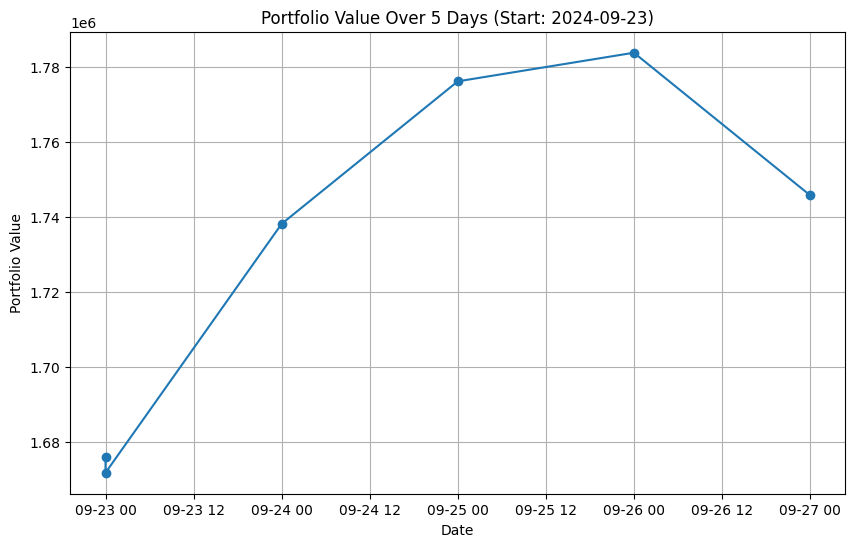


Backtesting starting on: 2024-10-21
Trading Days: [datetime.date(2024, 10, 21), datetime.date(2024, 10, 22), datetime.date(2024, 10, 23), datetime.date(2024, 10, 24), datetime.date(2024, 10, 25)]
Initial Portfolio Value: 1,734,300.05

Decision Log:
Date        Action      NVDA Open    Target Max NVDA    NVDQ Open    Target Min NVDQ  Portfolio Value    Profit/Loss    NVDA Shares      NVDQ Shares
----------  --------  -----------  -----------------  -----------  -----------------  -----------------  -------------  -------------  -------------
2024-10-21  BULLISH        138.13             144.42         3.53               3.21  1,804,360.11       70,060.07      12,555                     0
2024-10-22  BULLISH        142.91             144.42         3.28               3.21  1,802,853.32       -1,506.80      12,555                     0
2024-10-23  BULLISH        142.03             144.13         3.31               3.21  1,752,254.41       -50,598.91     12,555                     0
2024-

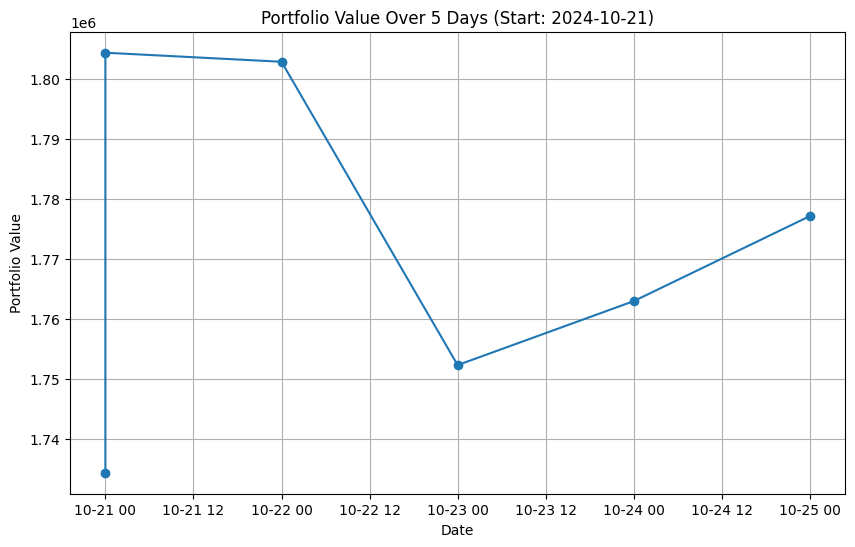


Backtesting starting on: 2024-11-18
Trading Days: [datetime.date(2024, 11, 18), datetime.date(2024, 11, 19), datetime.date(2024, 11, 20), datetime.date(2024, 11, 21), datetime.date(2024, 11, 22)]
Initial Portfolio Value: 1,730,999.99

Decision Log:
Date        Action      NVDA Open    Target Max NVDA    NVDQ Open    Target Min NVDQ  Portfolio Value    Profit/Loss    NVDA Shares      NVDQ Shares
----------  --------  -----------  -----------------  -----------  -----------------  -----------------  -------------  -------------  -------------
2024-11-18  BULLISH        139.5              152.89         3.36               2.76  1,739,065.51       8,065.52       12,408                     0
2024-11-19  BULLISH        141.32             152.89         3.28               2.76  1,824,188.52       85,123.02      12,408                     0
2024-11-20  BULLISH        147.41             152.89         3                  2.76  1,810,290.95       -13,897.57     12,408                     0
2024-

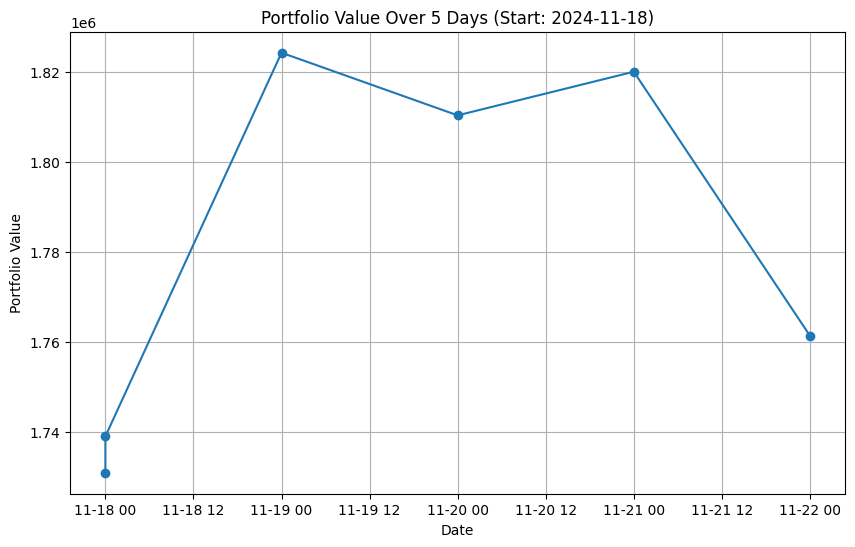


Backtesting Summary:
Start Date    Initial Value    Final Value    Total Profit/Loss
------------  ---------------  -------------  -------------------
2024-09-23    1,676,000.03     1,745,743.47   69,743.44
2024-10-21    1,734,300.05     1,777,114.37   42,814.33
2024-11-18    1,730,999.99     1,761,401.03   30,401.04


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from tabulate import tabulate
import joblib

# Step 1: Load Preprocessed Data
def load_preprocessed_csv(file_path):
    print(f"Loading preprocessed data from {file_path}...")
    df = pd.read_csv(file_path, index_col="Date", parse_dates=True)
    print(f"Data loaded with columns: {list(df.columns)}")
    return df

# Step 2: Load Models
def load_models(ticker):
    print(f"Loading models for {ticker}...")
    model_max = joblib.load(f"{ticker.lower()}_max_xgboost_model.pkl")
    model_min = joblib.load(f"{ticker.lower()}_min_xgboost_model.pkl")
    model_avg = joblib.load(f"{ticker.lower()}_avg_xgboost_model.pkl")
    return model_max, model_min, model_avg

# Step 3: Combined Trading Strategy
def combined_trading_strategy(
    dates_to_predict, nvda_data, nvdq_data, models_nvda, models_nvdq,
    initial_nvda_shares=10000, initial_nvdq_shares=100000,
    standard_threshold=0.002, volatility_threshold=0.03
):
    print(f"Combined Backtesting starting from: {dates_to_predict}")
    print(f"We have 10,000 shares of NVDA and 100,000 shares of NVDQ to start with")

    # Metrics summary table
    metrics_summary = []

    for start_date in dates_to_predict:
        start_date = pd.Timestamp(start_date)
        next_business_day = start_date + BDay(1)
        print(f"\nBacktesting starting on: {next_business_day.date()}")

        # Define trading days
        trading_days = pd.date_range(next_business_day, periods=5, freq=BDay())
        print(f"Trading Days: {[day.date() for day in trading_days]}")

        # Initial portfolio setup
        nvda_shares = initial_nvda_shares
        nvdq_shares = initial_nvdq_shares
        nvda_open_price = nvda_data.loc[next_business_day, 'Open']
        nvdq_open_price = nvdq_data.loc[next_business_day, 'Open']
        portfolio_value = (nvda_shares * nvda_open_price) + (nvdq_shares * nvdq_open_price)
        initial_value = portfolio_value

        print(f"Initial Portfolio Value: {portfolio_value:,.2f}")
        portfolio_values = [portfolio_value]
        daily_profit_loss = [0]

        # Decision Log
        decision_log = []

        # Backtesting loop
        for i, trading_day in enumerate(trading_days):
            if trading_day not in nvda_data.index or trading_day not in nvdq_data.index:
                print(f"Skipping {trading_day.date()} due to missing data.")
                portfolio_values.append(portfolio_value)
                daily_profit_loss.append(0)
                continue

            # Features for model prediction
            features = ['Open', 'High', 'Low', 'Close', '5-Day MA', '10-Day MA',
                        'Daily Return (%)', 'Volatility', 'Close_Lag1', 'Close_Lag2',
                        'Close_Lag3', 'Close_Lag4', 'Close_Lag5']
            X_nvda = nvda_data.loc[[trading_day], features].values
            X_nvdq = nvdq_data.loc[[trading_day], features].values

            # Predictions
            target_max_nvda = models_nvda[0].predict(X_nvda)[0]
            target_min_nvdq = models_nvdq[1].predict(X_nvdq)[0]

            # Open prices
            nvda_open = nvda_data.loc[trading_day, 'Open']
            nvdq_open = nvdq_data.loc[trading_day, 'Open']

            # Decision Logic
            action = "IDLE"
            if target_max_nvda > nvda_open * (1 + standard_threshold):
                action = "BULLISH"
                total_value = (nvdq_shares * nvdq_open) + (nvda_shares * nvda_open)
                nvda_shares = total_value / nvda_open
                nvdq_shares = 0
            elif target_min_nvdq < nvdq_open * (1 - standard_threshold):
                action = "BEARISH"
                total_value = (nvda_shares * nvda_open) + (nvdq_shares * nvdq_open)
                nvdq_shares = total_value / nvdq_open
                nvda_shares = 0

            # Update Portfolio Value
            nvda_close = nvda_data.loc[trading_day, 'Close']
            nvdq_close = nvdq_data.loc[trading_day, 'Close']
            prev_portfolio_value = portfolio_value
            portfolio_value = (nvda_shares * nvda_close) + (nvdq_shares * nvdq_close)
            profit_loss = portfolio_value - prev_portfolio_value

            # Append to decision log
            decision_log.append([
                trading_day.date(), action, f"{nvda_open:,.2f}", f"{target_max_nvda:,.2f}",
                f"{nvdq_open:,.2f}", f"{target_min_nvdq:,.2f}", f"{portfolio_value:,.2f}",
                f"{profit_loss:,.2f}", f"{int(nvda_shares):,}", f"{int(nvdq_shares):,}"
            ])

            # Update tracking
            portfolio_values.append(portfolio_value)
            daily_profit_loss.append(profit_loss)

        # Final Metrics
        total_profit_loss = portfolio_value - initial_value
        metrics_summary.append([next_business_day.date(), f"{initial_value:,.2f}", f"{portfolio_value:,.2f}", f"{total_profit_loss:,.2f}"])

        # Print Decision Log
        print("\nDecision Log:")
        print(tabulate(decision_log, headers=["Date", "Action", "NVDA Open", "Target Max NVDA",
                                              "NVDQ Open", "Target Min NVDQ", "Portfolio Value",
                                              "Profit/Loss", "NVDA Shares", "NVDQ Shares"]))

        # Plot Portfolio Value
        plt.figure(figsize=(10, 6))
        plt.title(f"Portfolio Value Over 5 Days (Start: {next_business_day.date()})")
        plt.plot(trading_days.insert(0, next_business_day), portfolio_values, marker='o')
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.grid()
        plt.show()

    # Print Summary
    print("\nBacktesting Summary:")
    print(tabulate(metrics_summary, headers=["Start Date", "Initial Value", "Final Value", "Total Profit/Loss"]))


# Step 4: Execution
if __name__ == "__main__":
    dates_to_predict = ['2024-09-22', '2024-10-20', '2024-11-17']

    # Load Preprocessed Data
    nvda_data = load_preprocessed_csv('nvda_preprocessed.csv')
    nvdq_data = load_preprocessed_csv('nvdq_preprocessed.csv')

    # Load Models
    models_nvda = load_models("NVDA")
    models_nvdq = load_models("NVDQ")

    # Run Backtesting
    combined_trading_strategy(
        dates_to_predict=dates_to_predict,
        nvda_data=nvda_data,
        nvdq_data=nvdq_data,
        models_nvda=models_nvda,
        models_nvdq=models_nvdq,
        standard_threshold=0.002,
        volatility_threshold=0.03
    )
